In [1]:
# !pip install seaborn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
directory_to_img = os.path.join('..', '..', 'images')

In [7]:
seed = 2023

In [152]:
start = datetime(2010, 1, 1)
end = datetime(2023, 10, 31)


tckr = 'CT=F'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

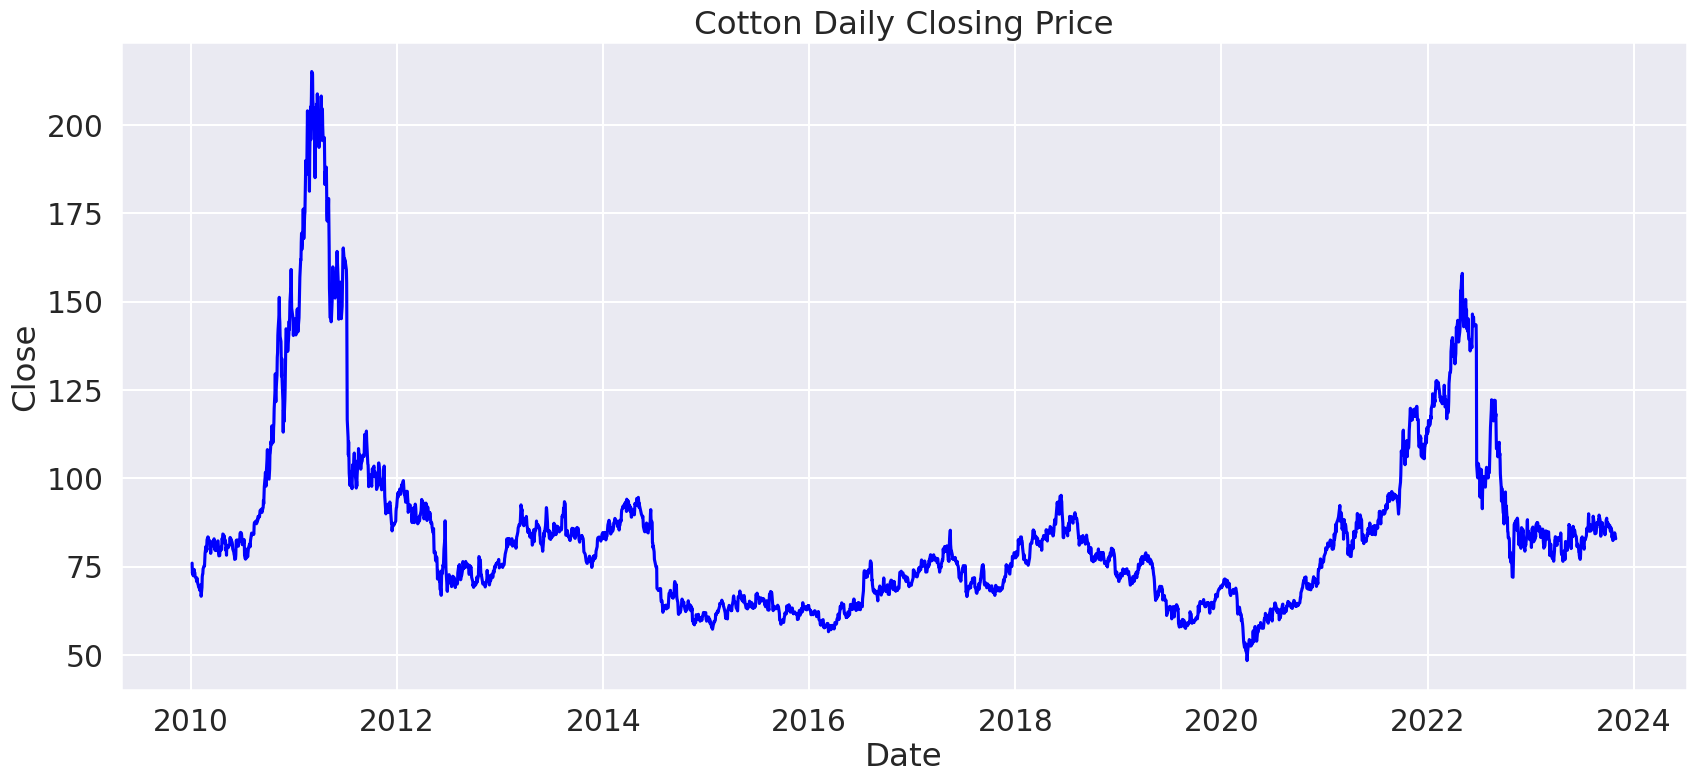

In [153]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('Cotton Daily Closing Price')    


In [154]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

In [155]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [156]:
df.head()

Open       High        Low      Close  Volume  \
Date                                                                            
2010-01-04 00:00:00-05:00  75.900002  76.769997  75.669998  76.000000   10595   
2010-01-05 00:00:00-05:00  75.860001  76.279999  73.040001  73.120003   24242   
2010-01-06 00:00:00-05:00  73.199997  74.269997  73.150002  73.550003   11376   
2010-01-07 00:00:00-05:00  73.970001  74.120003  72.559998  72.889999   11138   
2010-01-08 00:00:00-05:00  72.949997  73.400002  72.430000  72.440002    8906   

                           Dividends  Stock Splits   returns  log_returns  
Date                                                                       
2010-01-04 00:00:00-05:00        0.0           0.0       NaN          NaN  
2010-01-05 00:00:00-05:00        0.0           0.0 -3.789470    -0.038631  
2010-01-06 00:00:00-05:00        0.0           0.0  0.588075     0.005864  
2010-01-07 00:00:00-05:00        0.0           0.0 -0.897354    -0.009014  
2010-01-08 00:00:00-05:00        0.0           0.0 -0.617364    -0.006193

In [157]:
# DROPPING THE 1ST ROW OF DATA 
# SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

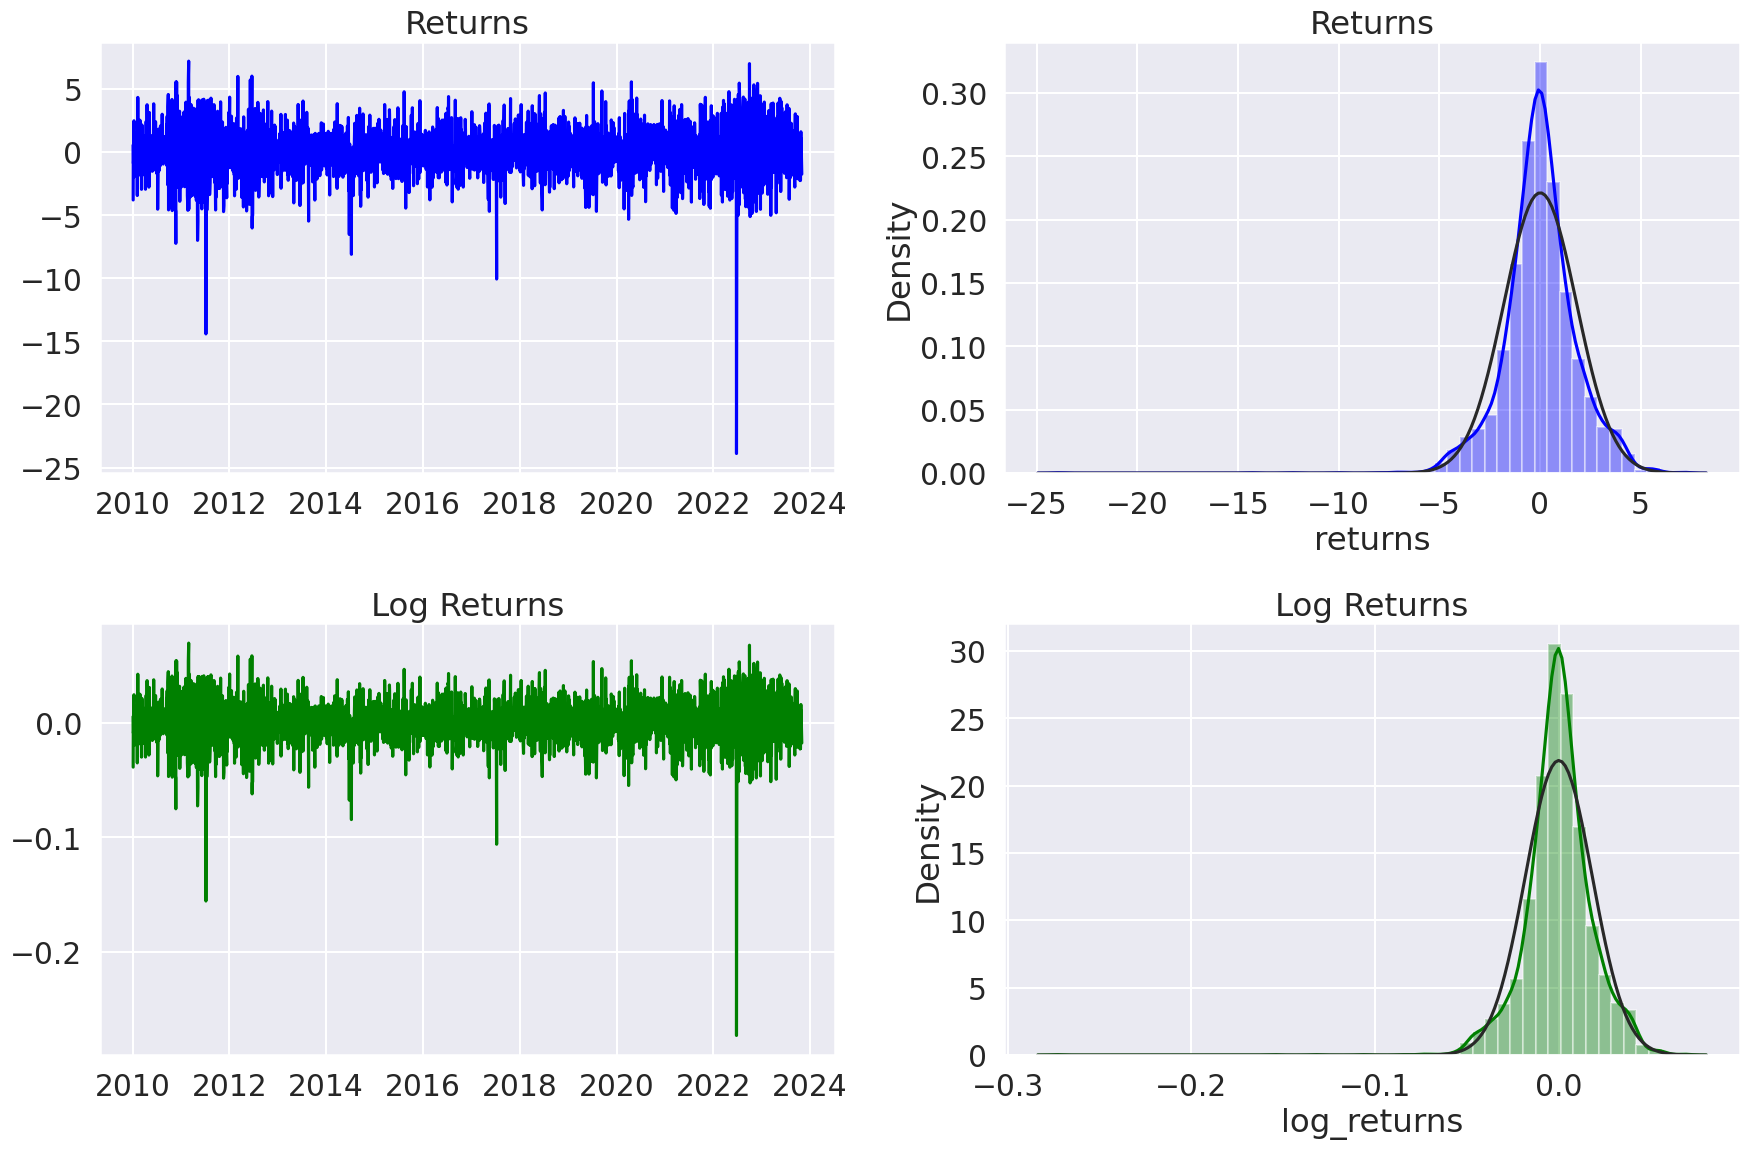

In [158]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    fig.show();

In [15]:
df.returns.describe()

count    3476.000000
mean        0.018998
std         1.804070
min       -23.884979
25%        -0.880089
50%         0.000000
75%         0.948466
max         7.212294
Name: returns, dtype: float64

In [16]:
df.log_returns.describe()

count    3476.000000
mean        0.000025
std         0.018236
min        -0.272925
25%        -0.008840
50%         0.000000
75%         0.009440
max         0.069641
Name: log_returns, dtype: float64

In [159]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [160]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

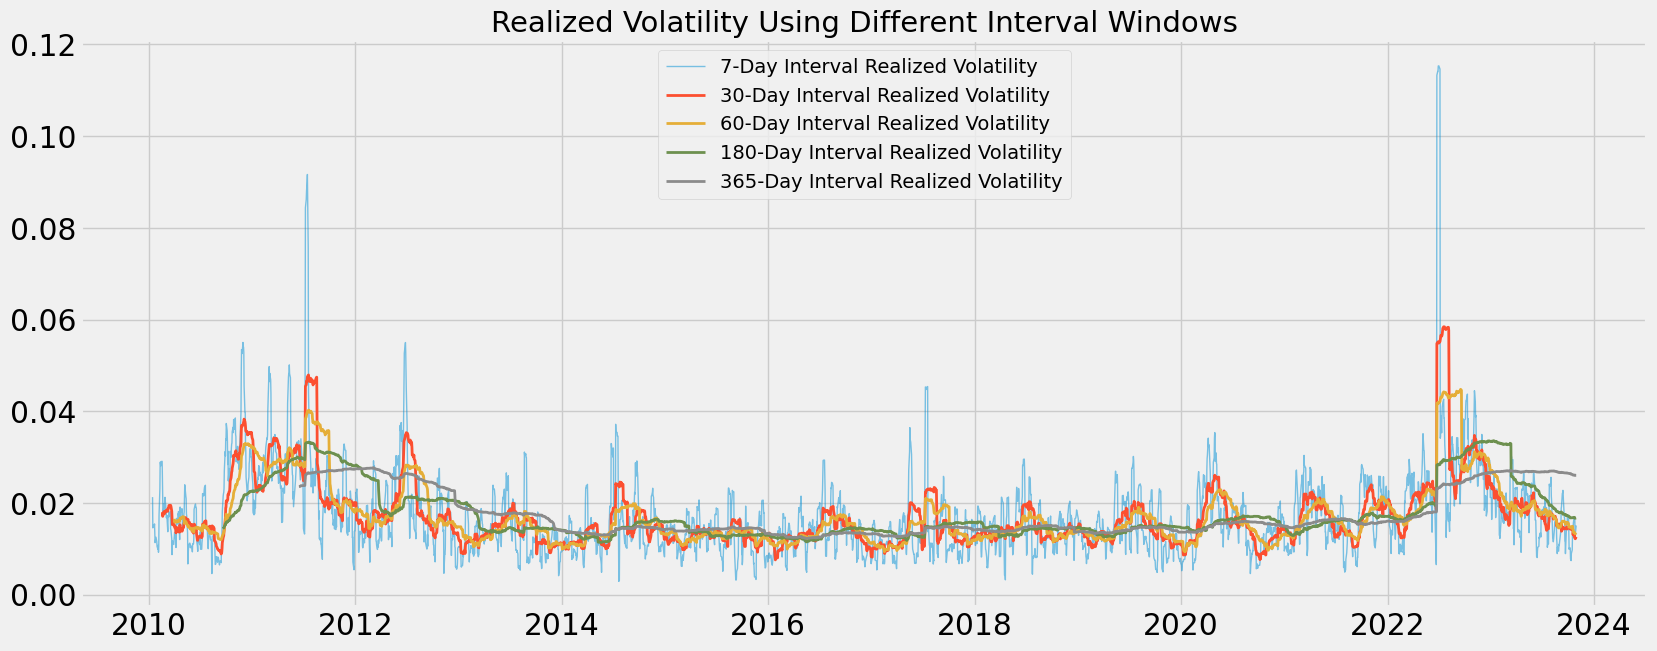

In [161]:

plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})

plt.show();

In [162]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [163]:
# df.describe()
df_ = df.reset_index()
df_['year'] = df_['Date'].dt.year
print(df_.groupby('year')['Date'].count())

year
2010    251
2011    252
2012    250
2013    252
2014    252
2015    251
2016    250
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    208
Name: Date, dtype: int64


In [164]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [23]:
df.describe()

Open         High          Low        Close        Volume  \
count  3476.000000  3476.000000  3476.000000  3476.000000   3476.000000   
mean     84.122791    85.007949    83.259724    84.064289   9439.979287   
std      25.205282    25.793869    24.587445    25.148707   9868.041824   
min      48.950001    51.130001    48.349998    48.410000      0.000000   
25%      68.457499    68.989998    67.965000    68.387499     26.000000   
50%      79.384998    80.234997    78.599998    79.215000   8347.000000   
75%      88.072500    88.832500    87.242498    88.064999  16459.000000   
max     215.619995   227.000000   210.750000   215.149994  69381.000000   

           returns  log_returns  vol_current   vol_future  
count  3476.000000  3476.000000  3447.000000  3440.000000  
mean      0.018998     0.000025     0.017082     0.017080  
std       1.804070     0.018236     0.007289     0.007296  
min     -23.884979    -0.272925     0.007578     0.007578  
25%      -0.880089    -0.008840     0.012538     0.012532  
50%       0.000000     0.000000     0.014950     0.014943  
75%       0.948466     0.009440     0.019295     0.019315  
max       7.212294     0.069641     0.058419     0.058419

In [165]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

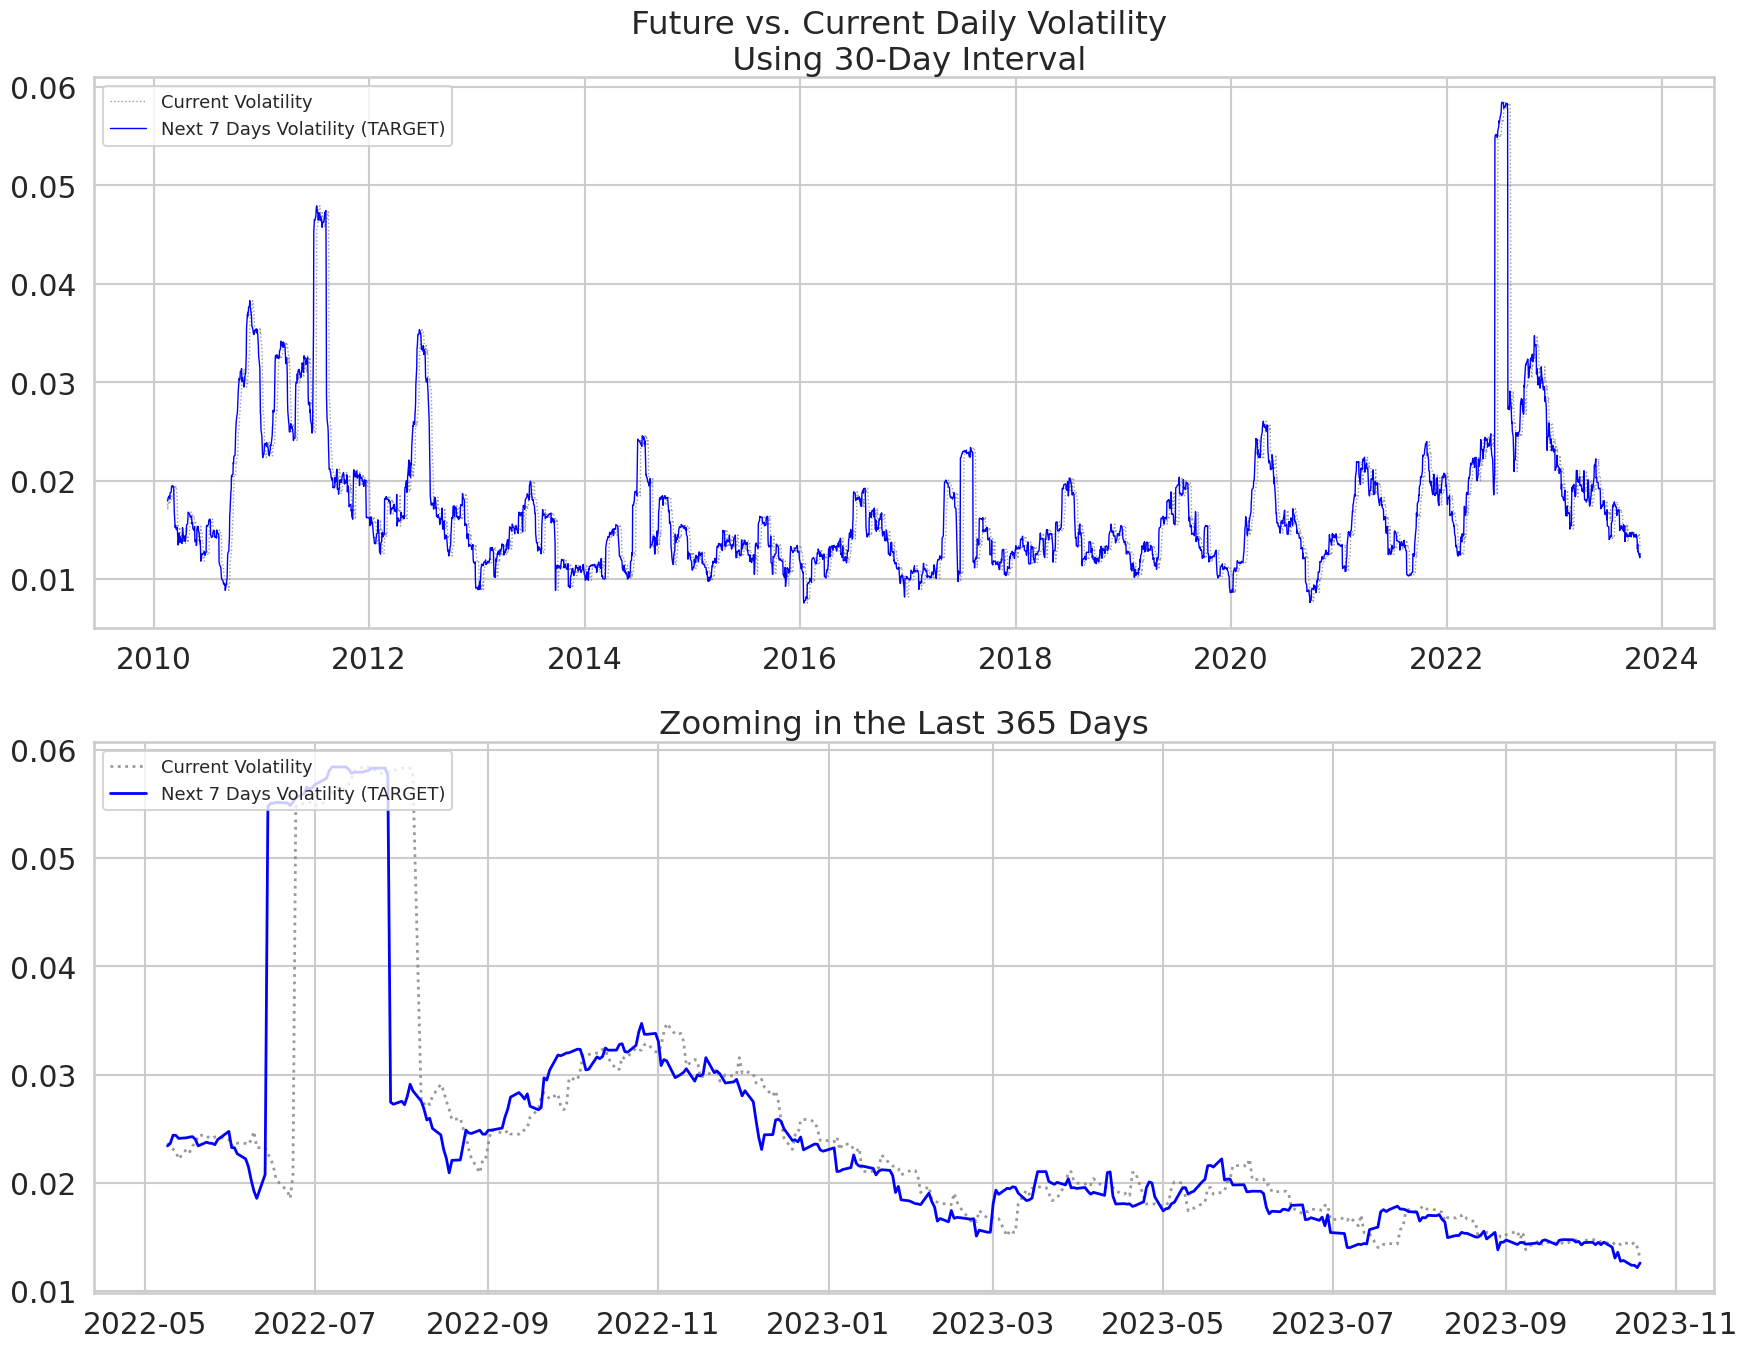

In [166]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
#     plt.savefig(os.path.join(directory_to_img, 'daily_vol.jpg'), 
#                 dpi=300, bbox_inches='tight')
    plt.show();

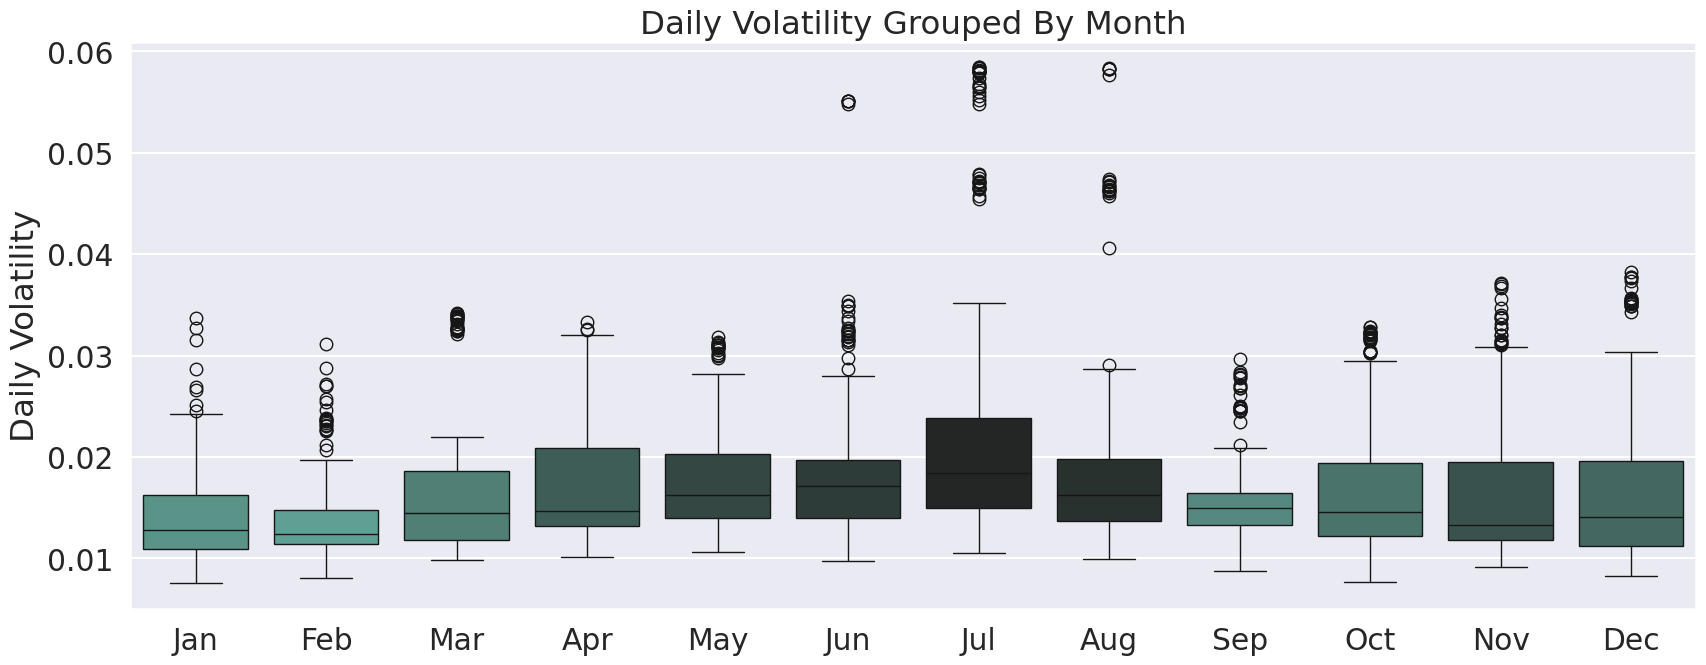

In [167]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("dark:#5A9_r", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.show()

In [27]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2022-07-18 00:00:00-04:00    0.058419
2022-07-21 00:00:00-04:00    0.058413
2022-07-19 00:00:00-04:00    0.058407
2022-07-20 00:00:00-04:00    0.058405
2022-08-04 00:00:00-04:00    0.058312
2022-08-03 00:00:00-04:00    0.058311
2022-08-02 00:00:00-04:00    0.058303
2022-08-01 00:00:00-04:00    0.058293
2022-07-22 00:00:00-04:00    0.058207
2022-07-15 00:00:00-04:00    0.058073
2022-07-29 00:00:00-04:00    0.058064
2022-07-28 00:00:00-04:00    0.058049
2022-07-26 00:00:00-04:00    0.057933
2022-07-27 00:00:00-04:00    0.057929
2022-07-25 00:00:00-04:00    0.057819
2022-08-05 00:00:00-04:00    0.057637
2022-07-14 00:00:00-04:00    0.057360
2022-07-13 00:00:00-04:00    0.056809
2022-07-08 00:00:00-04:00    0.056553
2022-07-12 00:00:00-04:00    0.056534
2022-07-11 00:00:00-04:00    0.056359
2022-07-07 00:00:00-04:00    0.055962
2022-07-06 00:00:00-04:00    0.055574
2022-07-05 00:00:00-04:00    0.055189
2022-06-29 00:00:00-04:00    0.055152
2022-06-30 00:00:00-04:00    0.055088
2022-06

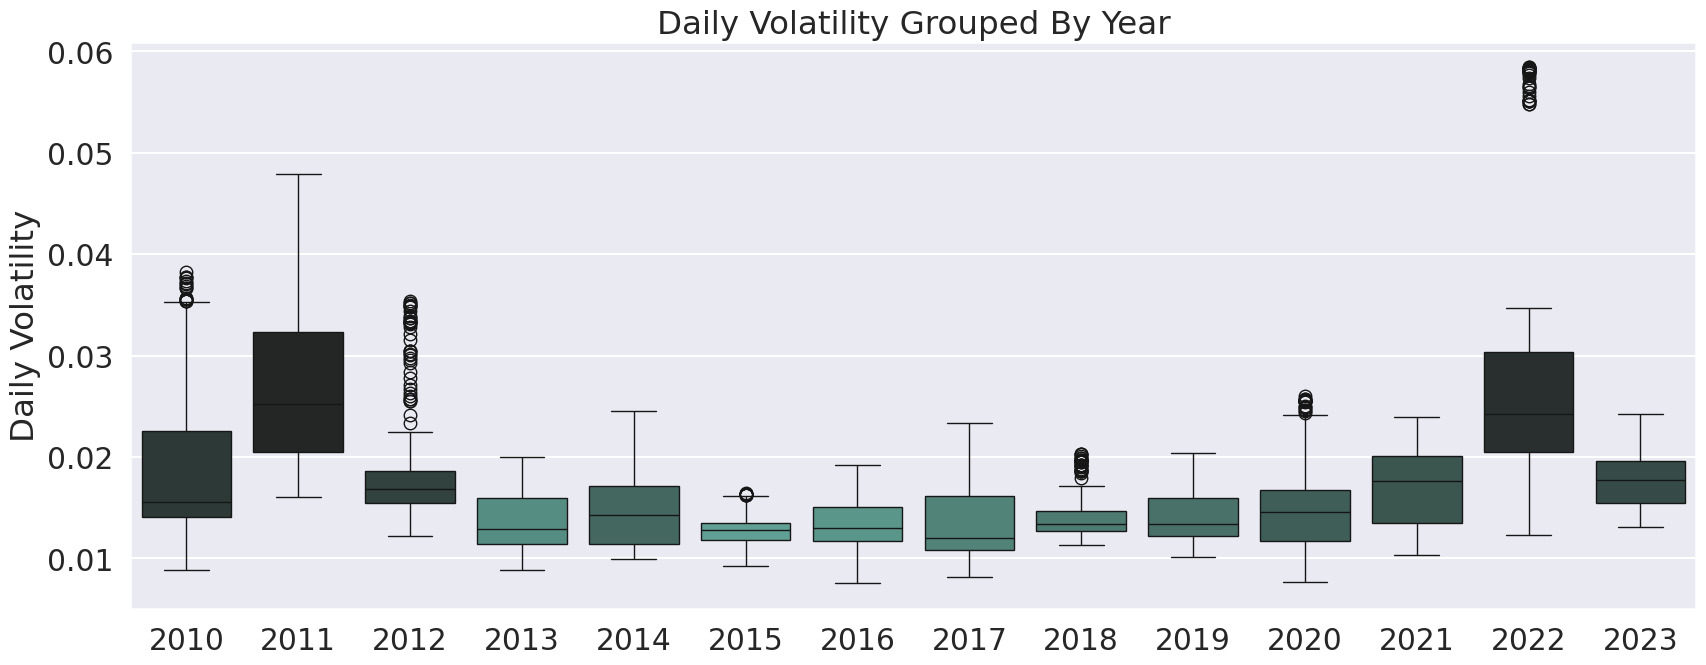

In [168]:

# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("dark:#5A9_r", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.show()

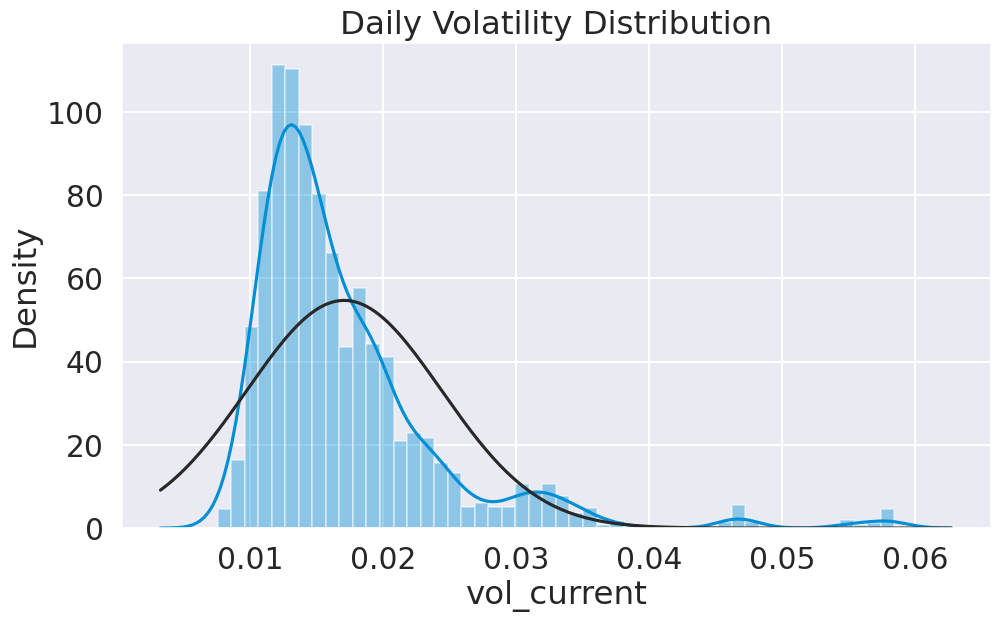

In [169]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show();

In [30]:
from statsmodels.tsa.stattools import adfuller

In [170]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -52.3251287880284
p-value: 0.0
Critical Values:
1%: -3.4323
5%: -2.8624
10%: -2.5672


In [171]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -52.54401146872397
p-value: 0.0
Critical Values:
1%: -3.4323
5%: -2.8624
10%: -2.5672


In [172]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

print(len(val_idx))

365


In [173]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2010-02-17 00:00:00-05:00 	to: 2022-03-24 00:00:00-04:00 	3045 days
VALIDATION 	From: 2022-03-25 00:00:00-04:00 	to: 2023-09-07 00:00:00-04:00 	365 days
TEST 		From: 2023-09-08 00:00:00-04:00 	to: 2023-10-19 00:00:00-04:00 	30 days


In [174]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [175]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [176]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [177]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [178]:
print(x_val)

Date
2022-03-25 00:00:00-04:00    0.019829
2022-03-28 00:00:00-04:00    0.020279
2022-03-29 00:00:00-04:00    0.020202
2022-03-30 00:00:00-04:00    0.020607
2022-03-31 00:00:00-04:00    0.021284
                               ...   
2023-08-31 00:00:00-04:00    0.014996
2023-09-01 00:00:00-04:00    0.015213
2023-09-05 00:00:00-04:00    0.015543
2023-09-06 00:00:00-04:00    0.014822
2023-09-07 00:00:00-04:00    0.015427
Name: vol_current, Length: 365, dtype: float64


In [40]:
print(val_idx)

DatetimeIndex(['2022-03-25 00:00:00-04:00', '2022-03-28 00:00:00-04:00',
               '2022-03-29 00:00:00-04:00', '2022-03-30 00:00:00-04:00',
               '2022-03-31 00:00:00-04:00', '2022-04-01 00:00:00-04:00',
               '2022-04-04 00:00:00-04:00', '2022-04-05 00:00:00-04:00',
               '2022-04-06 00:00:00-04:00', '2022-04-07 00:00:00-04:00',
               ...
               '2023-08-24 00:00:00-04:00', '2023-08-25 00:00:00-04:00',
               '2023-08-28 00:00:00-04:00', '2023-08-29 00:00:00-04:00',
               '2023-08-30 00:00:00-04:00', '2023-08-31 00:00:00-04:00',
               '2023-09-01 00:00:00-04:00', '2023-09-05 00:00:00-04:00',
               '2023-09-06 00:00:00-04:00', '2023-09-07 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=365, freq=None)


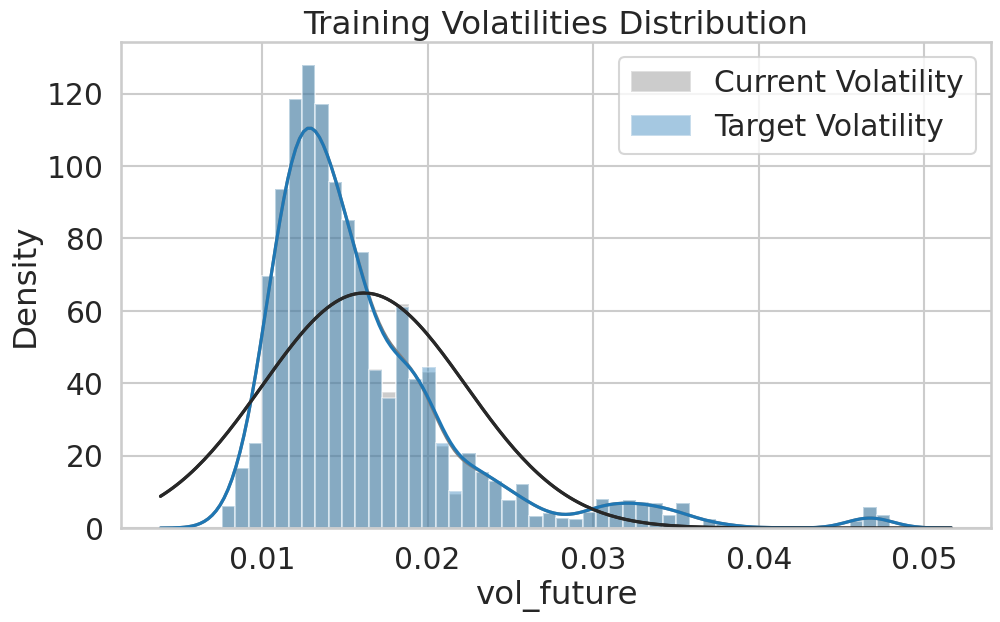

In [179]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show();

In [42]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)
x_train.head(10)

Date
2010-02-17 00:00:00-05:00    0.017992
2010-02-18 00:00:00-05:00    0.017075
2010-02-19 00:00:00-05:00    0.017584
2010-02-22 00:00:00-05:00    0.018083
2010-02-23 00:00:00-05:00    0.018127
2010-02-24 00:00:00-05:00    0.017606
2010-02-25 00:00:00-05:00    0.017836
2010-02-26 00:00:00-05:00    0.017979
2010-03-01 00:00:00-05:00    0.018027
2010-03-02 00:00:00-05:00    0.018232
Name: vol_current, dtype: float64

In [43]:
y_train.head(10)

Date
2010-02-17 00:00:00-05:00    0.017979
2010-02-18 00:00:00-05:00    0.018027
2010-02-19 00:00:00-05:00    0.018232
2010-02-22 00:00:00-05:00    0.018426
2010-02-23 00:00:00-05:00    0.018453
2010-02-24 00:00:00-05:00    0.018273
2010-02-25 00:00:00-05:00    0.018180
2010-02-26 00:00:00-05:00    0.018783
2010-03-01 00:00:00-05:00    0.018812
2010-03-02 00:00:00-05:00    0.019046
Name: vol_future, dtype: float64

In [44]:
x_train_scaled.head(10)

Date
2010-02-17 00:00:00-05:00    0.258170
2010-02-18 00:00:00-05:00    0.235439
2010-02-19 00:00:00-05:00    0.248062
2010-02-22 00:00:00-05:00    0.260440
2010-02-23 00:00:00-05:00    0.261536
2010-02-24 00:00:00-05:00    0.248620
2010-02-25 00:00:00-05:00    0.254322
2010-02-26 00:00:00-05:00    0.257864
2010-03-01 00:00:00-05:00    0.259038
2010-03-02 00:00:00-05:00    0.264129
dtype: float64

In [45]:
y_train_scaled.head(10)

Date
2010-02-17 00:00:00-05:00    0.257864
2010-02-18 00:00:00-05:00    0.259038
2010-02-19 00:00:00-05:00    0.264129
2010-02-22 00:00:00-05:00    0.268950
2010-02-23 00:00:00-05:00    0.269610
2010-02-24 00:00:00-05:00    0.265143
2010-02-25 00:00:00-05:00    0.262848
2010-02-26 00:00:00-05:00    0.277794
2010-03-01 00:00:00-05:00    0.278522
2010-03-02 00:00:00-05:00    0.284307
dtype: float64

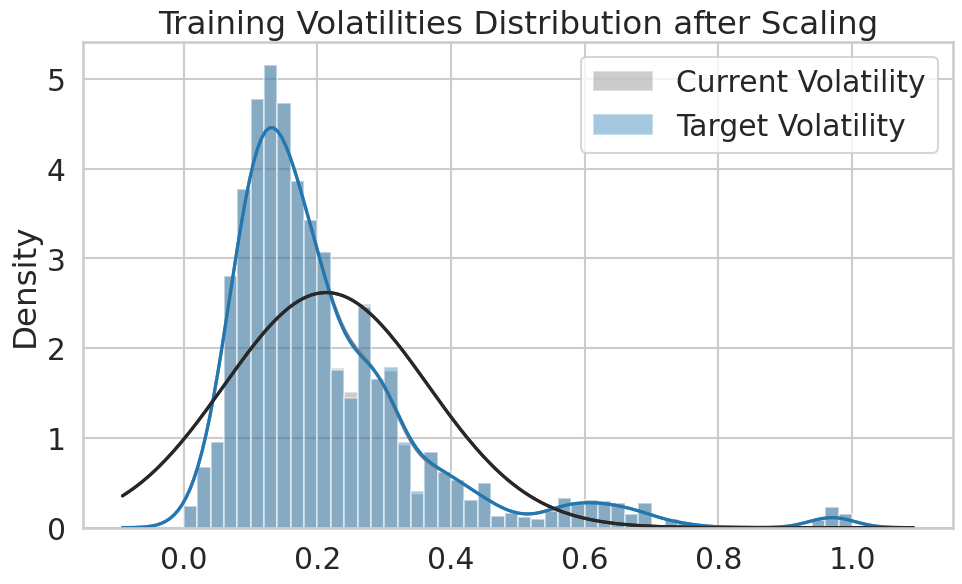

In [46]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show();

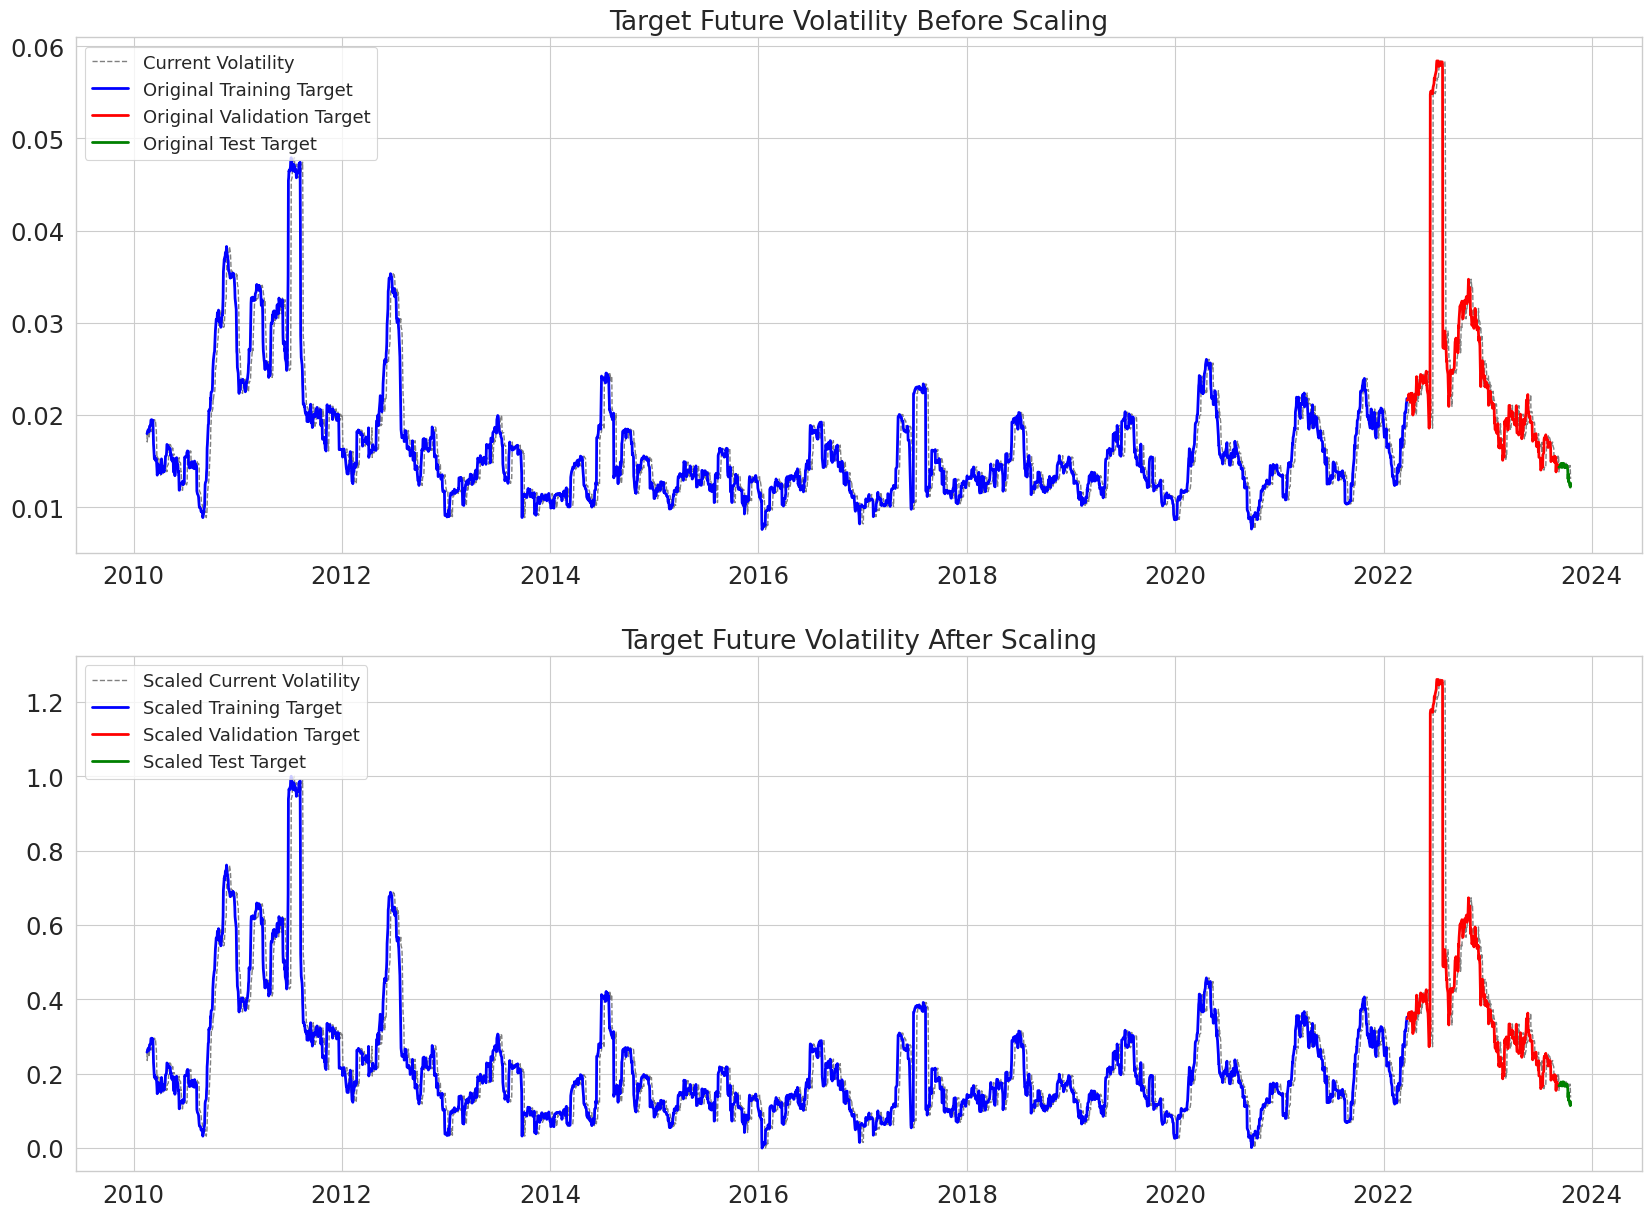

In [47]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='red', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='red', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show();

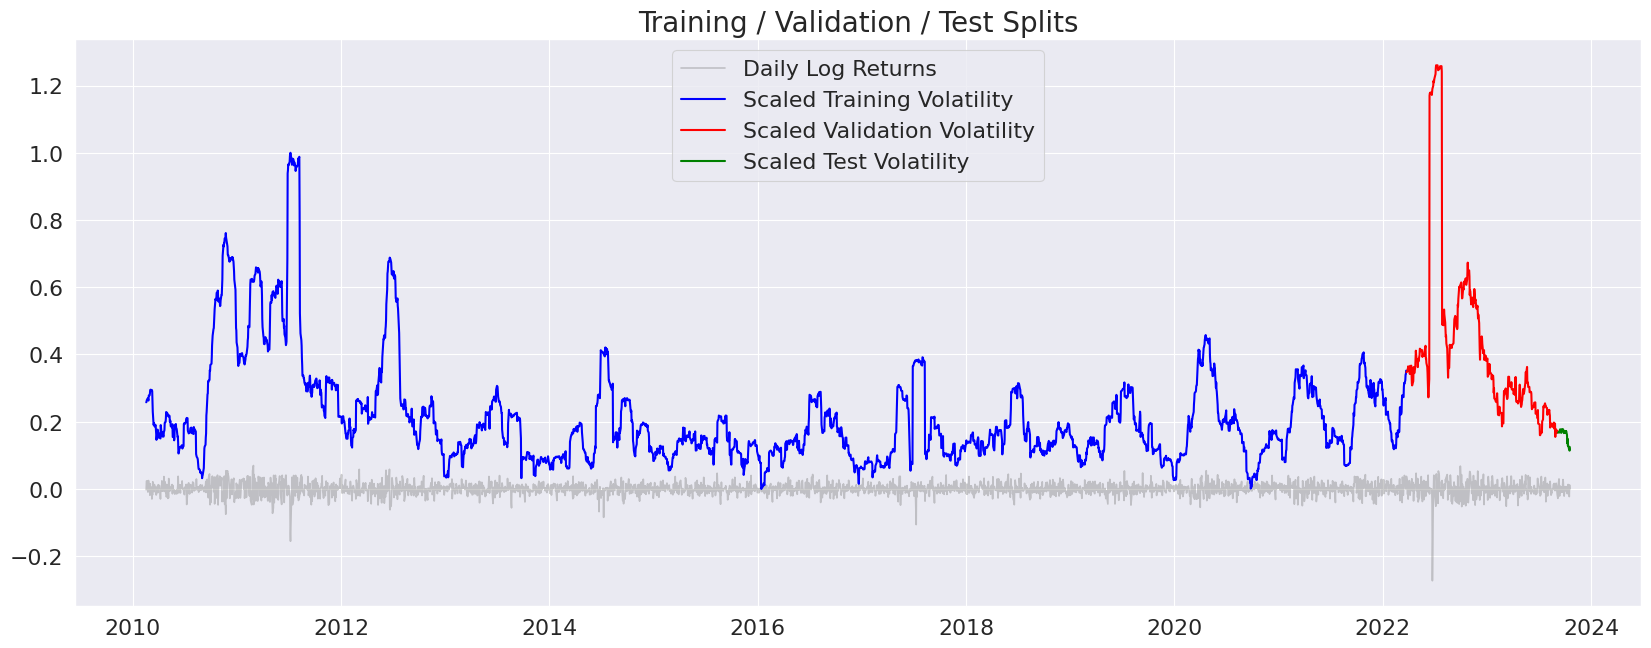

In [48]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.show();

In [49]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='red', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

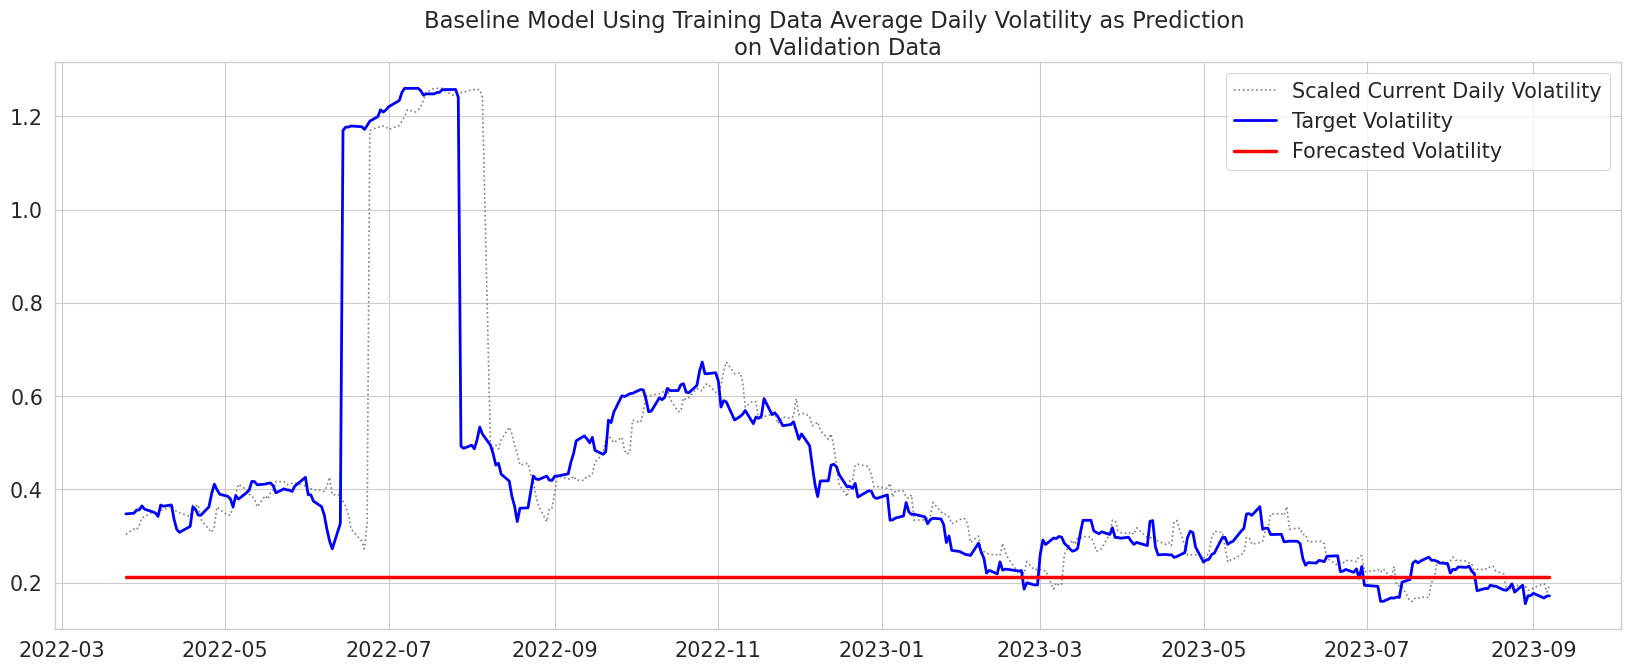

In [50]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)
viz_model(y_val_scaled, baseline_preds, 
          "Baseline Model Using Training Data Average Daily Volatility as Prediction")

plt.show();

In [51]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.456495         0.345204

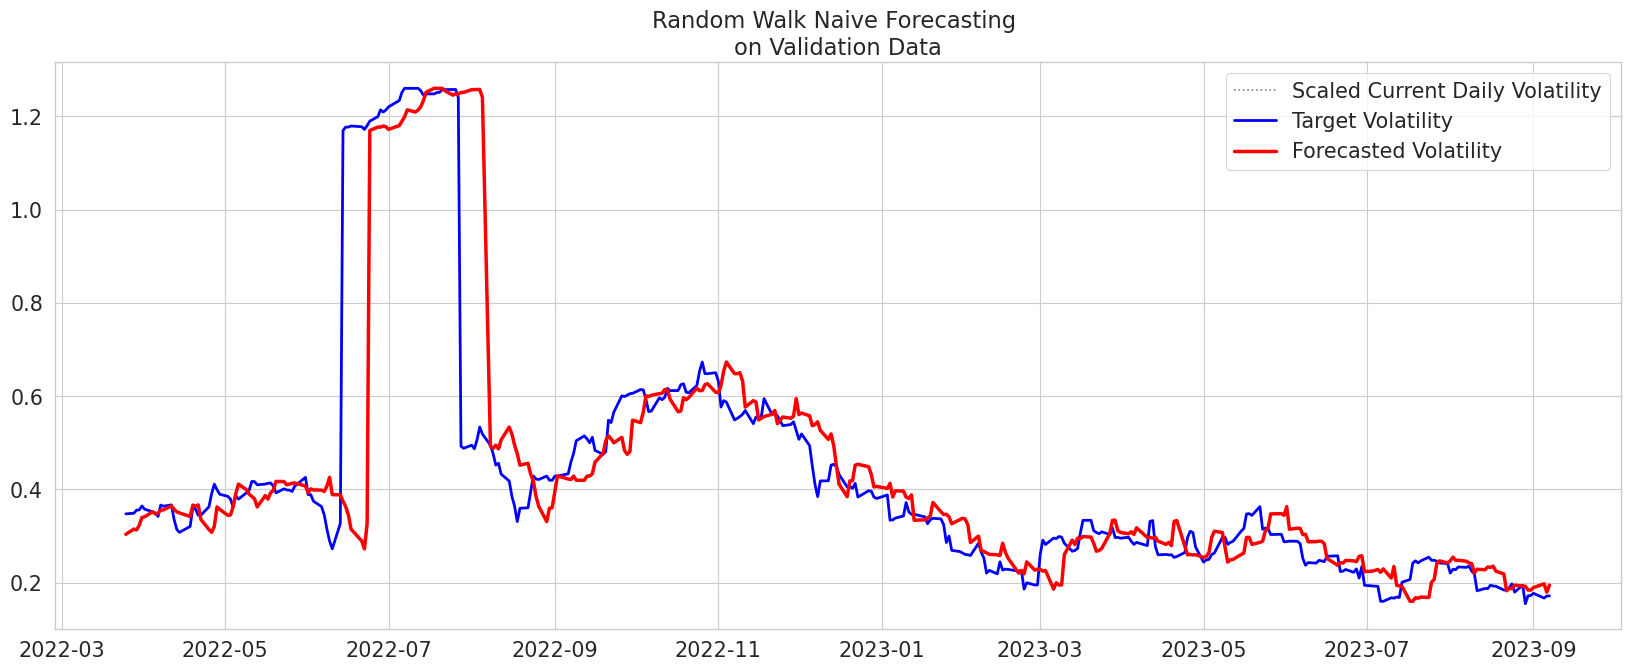

In [52]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show();

In [53]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          0.456495         0.345204
1  Random Walk Naive Forecasting          0.271457         0.164036

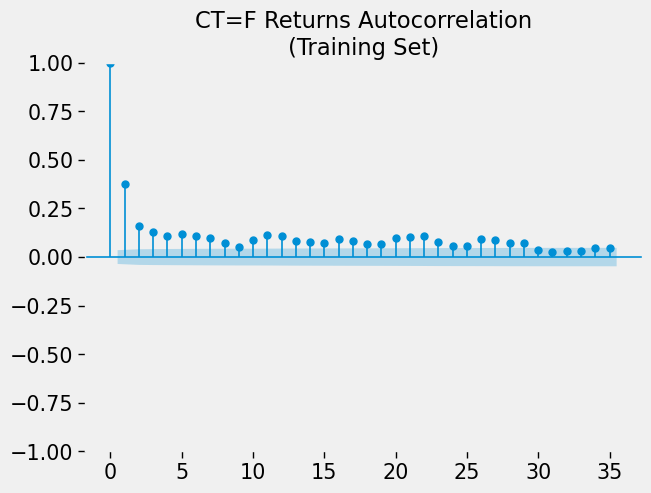

In [54]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

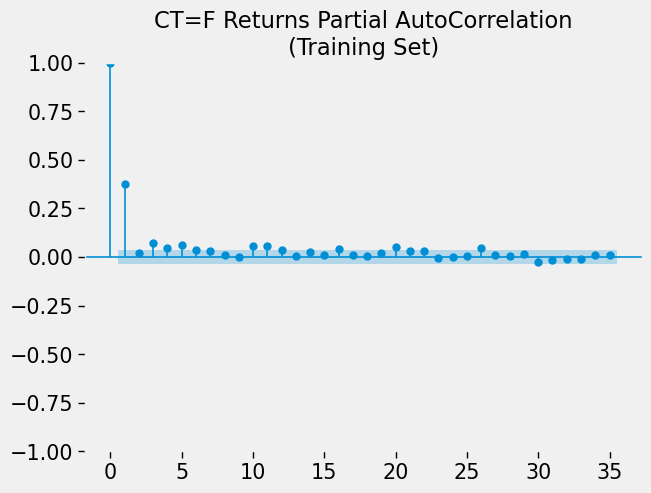

In [55]:

# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [56]:
from arch import arch_model
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5690.88
Distribution:                  Normal   AIC:                           11413.8
Method:            Maximum Likelihood   BIC:                           11510.1
                                        No. Observations:                 3045
Date:                Mon, Nov 06 2023   Df Residuals:                     3044
Time:                        22:37:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0557  2.741e-02      2.031  4.224e-02 [1.950e-

In [57]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5705.19
Distribution:                  Normal   AIC:                           11418.4
Method:            Maximum Likelihood   BIC:                           11442.5
                                        No. Observations:                 3045
Date:                Mon, Nov 06 2023   Df Residuals:                     3044
Time:                        22:37:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0511  2.719e-02      1.881  5.996e-02 [-2.1

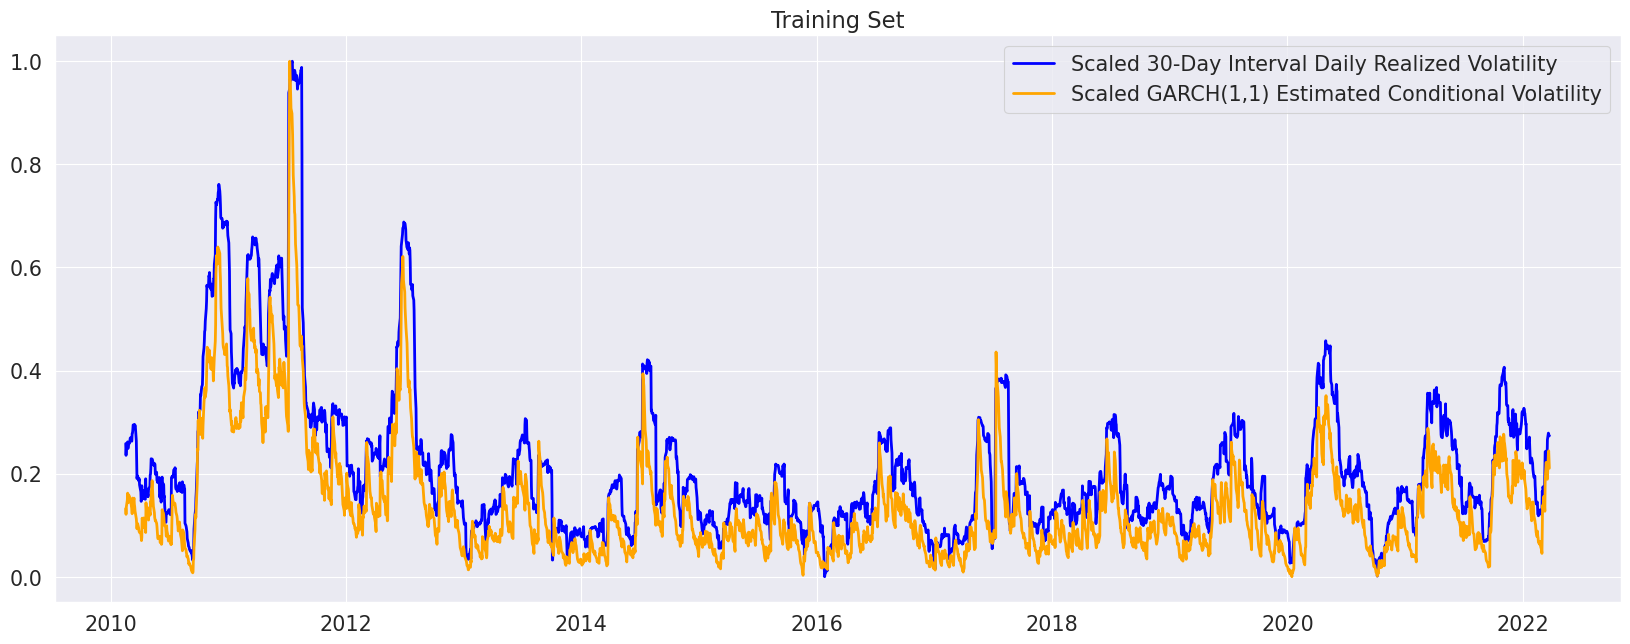

In [58]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

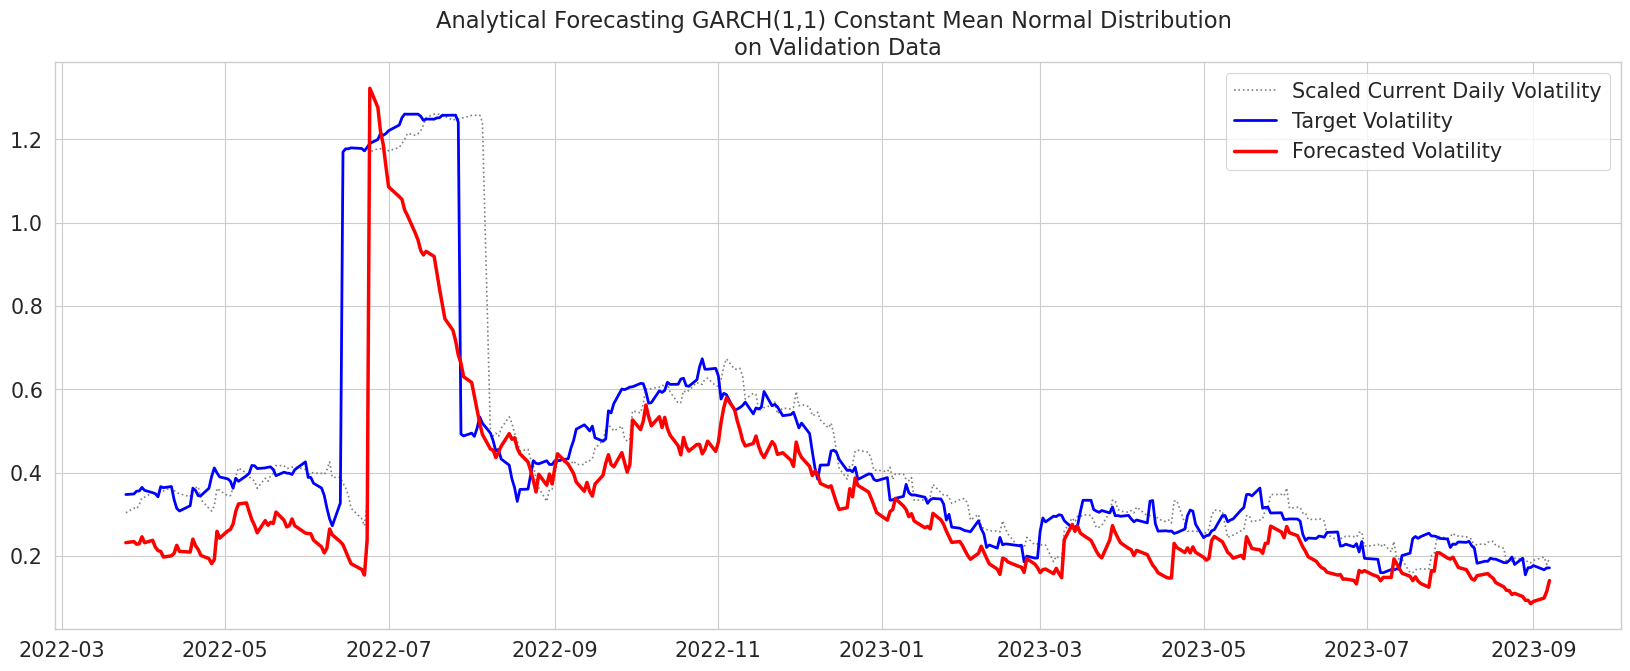

In [59]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [60]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          0.456495         0.345204
1           Random Walk Naive Forecasting          0.271457         0.164036
2  GARCH(1,1), Constant Mean, Normal Dist          0.286458         0.182267

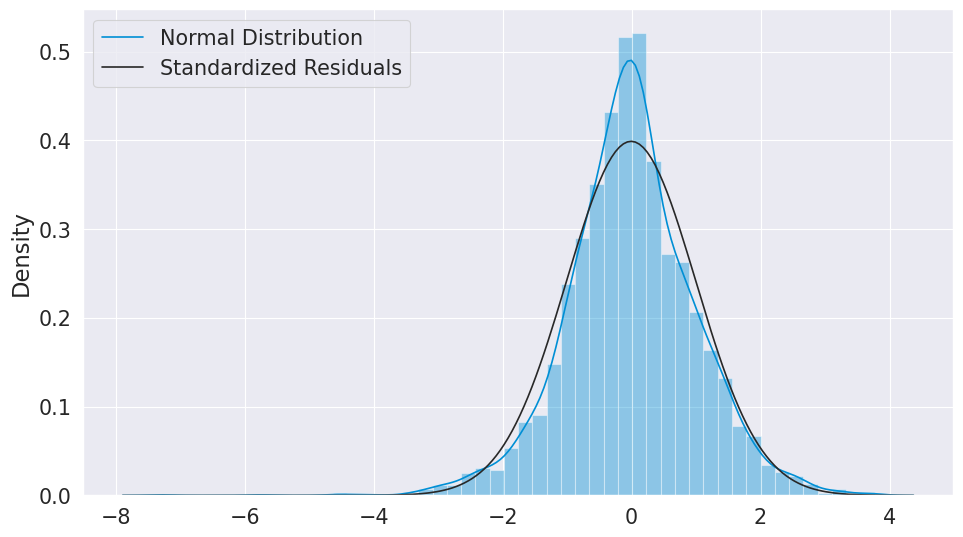

In [61]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

In [62]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5636.19
Distribution:      Standardized Skew Student's t   AIC:                           11286.4
Method:                       Maximum Likelihood   BIC:                           11328.5
                                                   No. Observations:                 3045
Date:                           Mon, Nov 06 2023   Df Residuals:                     3044
Time:                                   22:37:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

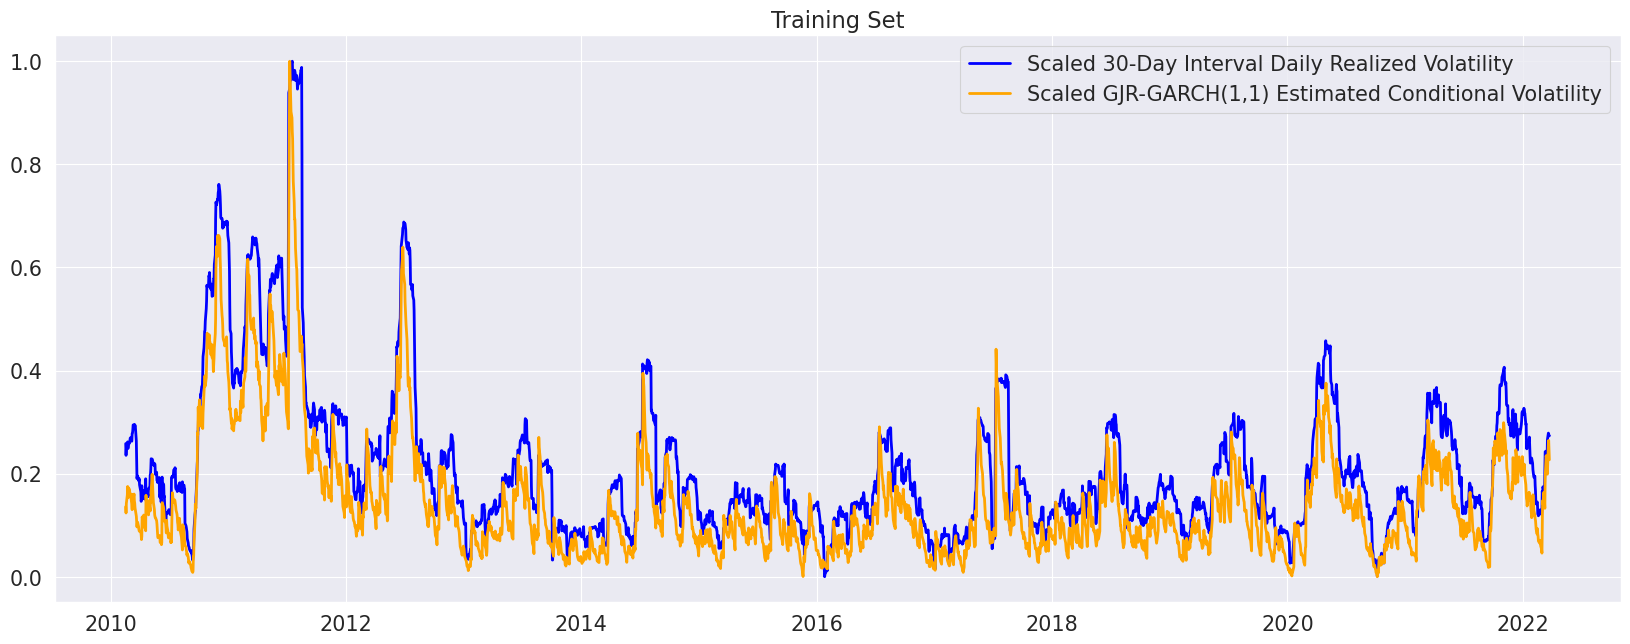

In [63]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

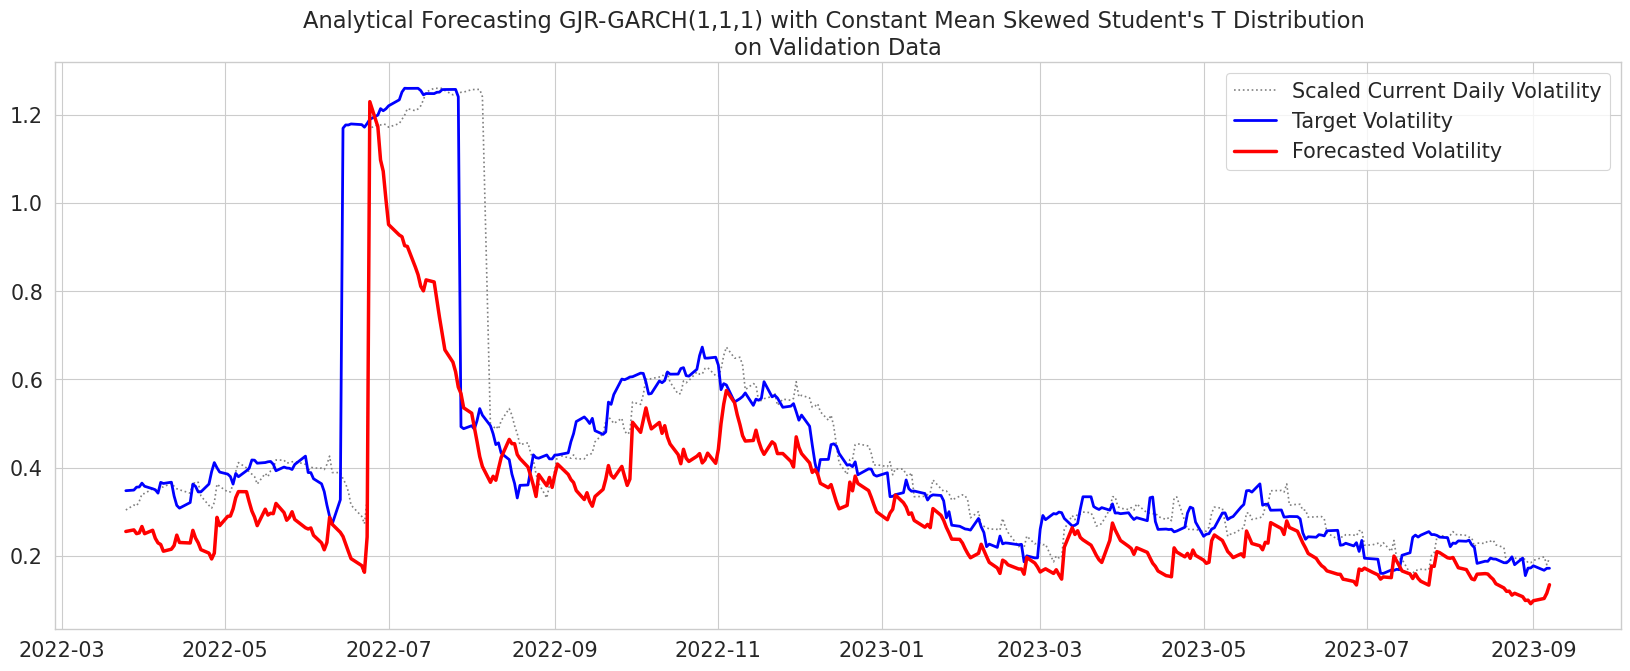

In [64]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [65]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658

In [66]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -5626.45
Distribution:      Standardized Skew Student's t   AIC:                           11266.9
Method:                       Maximum Likelihood   BIC:                           11309.0
                                                   No. Observations:                 3045
Date:                           Mon, Nov 06 2023   Df Residuals:                     3044
Time:                                   22:38:11   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

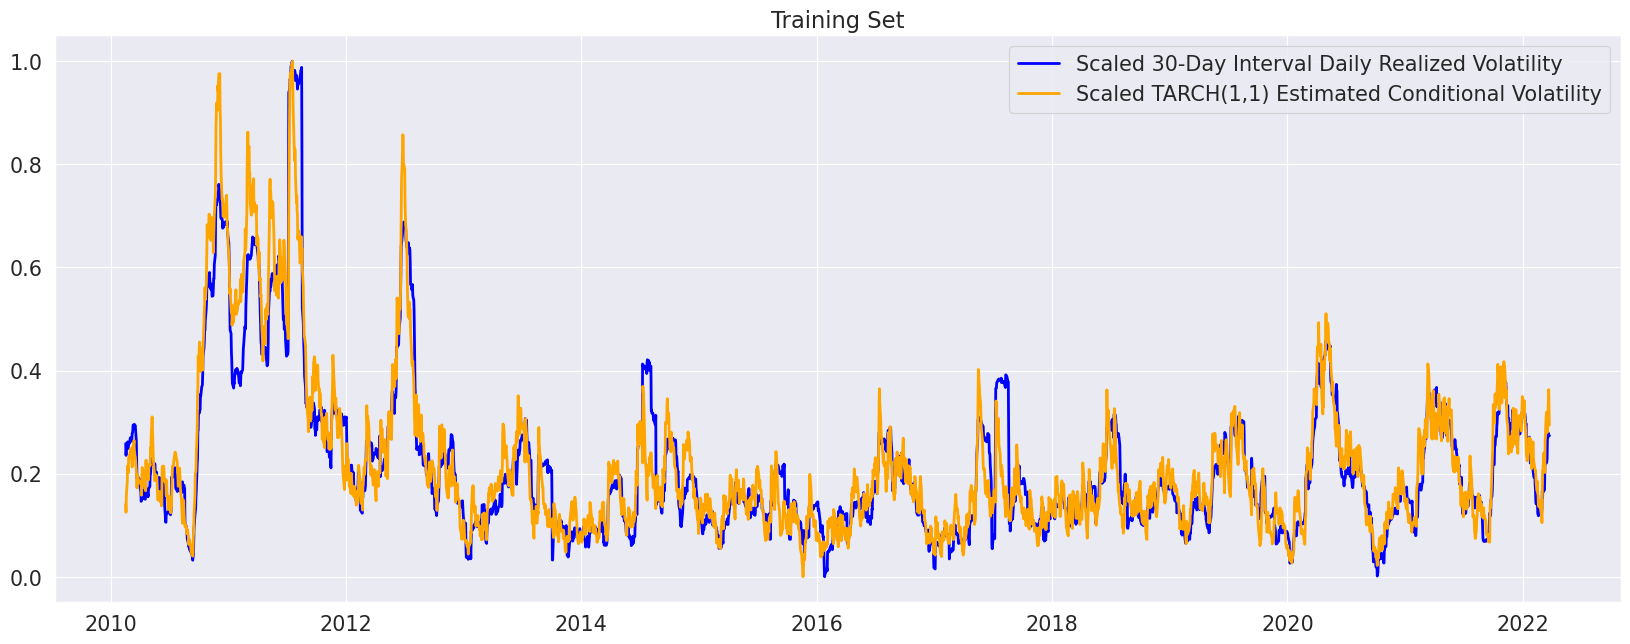

In [67]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

In [68]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

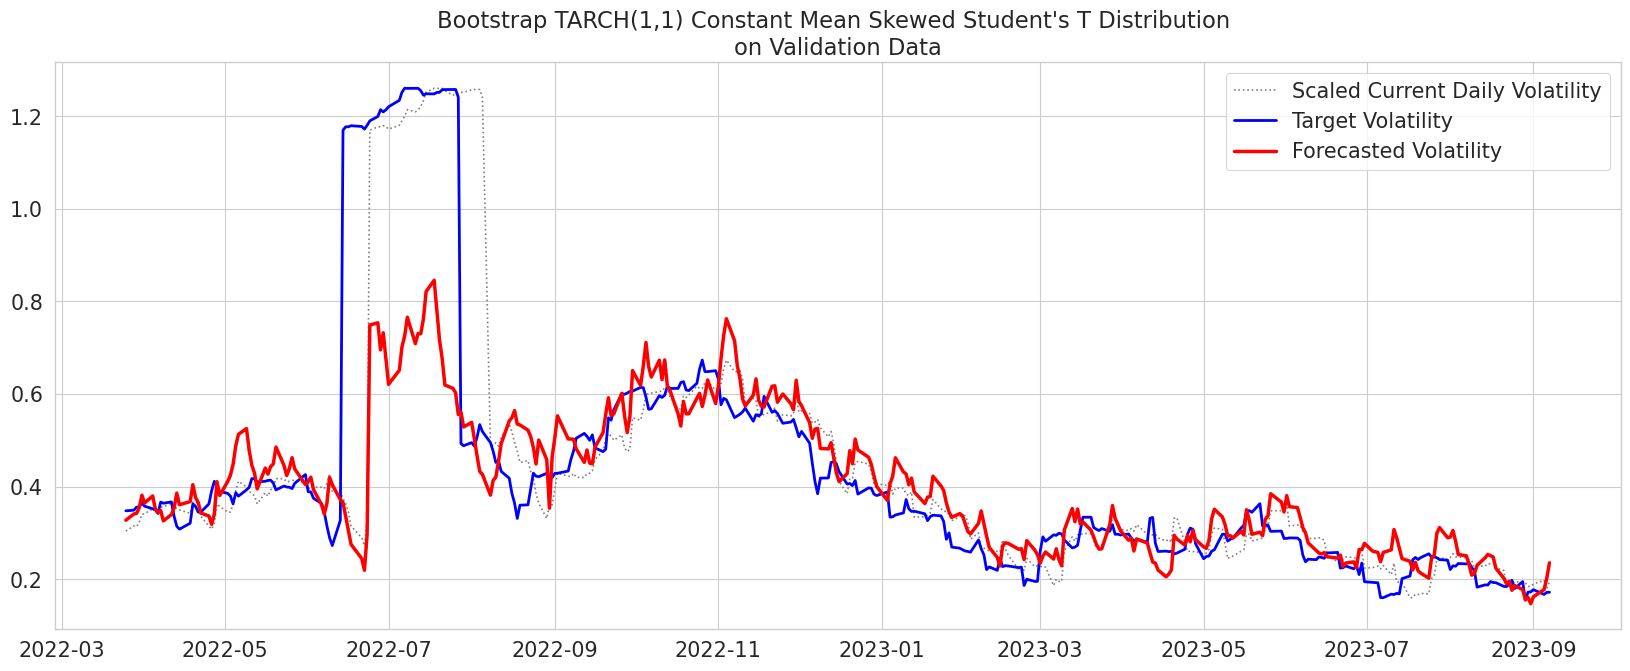

In [69]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [70]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904

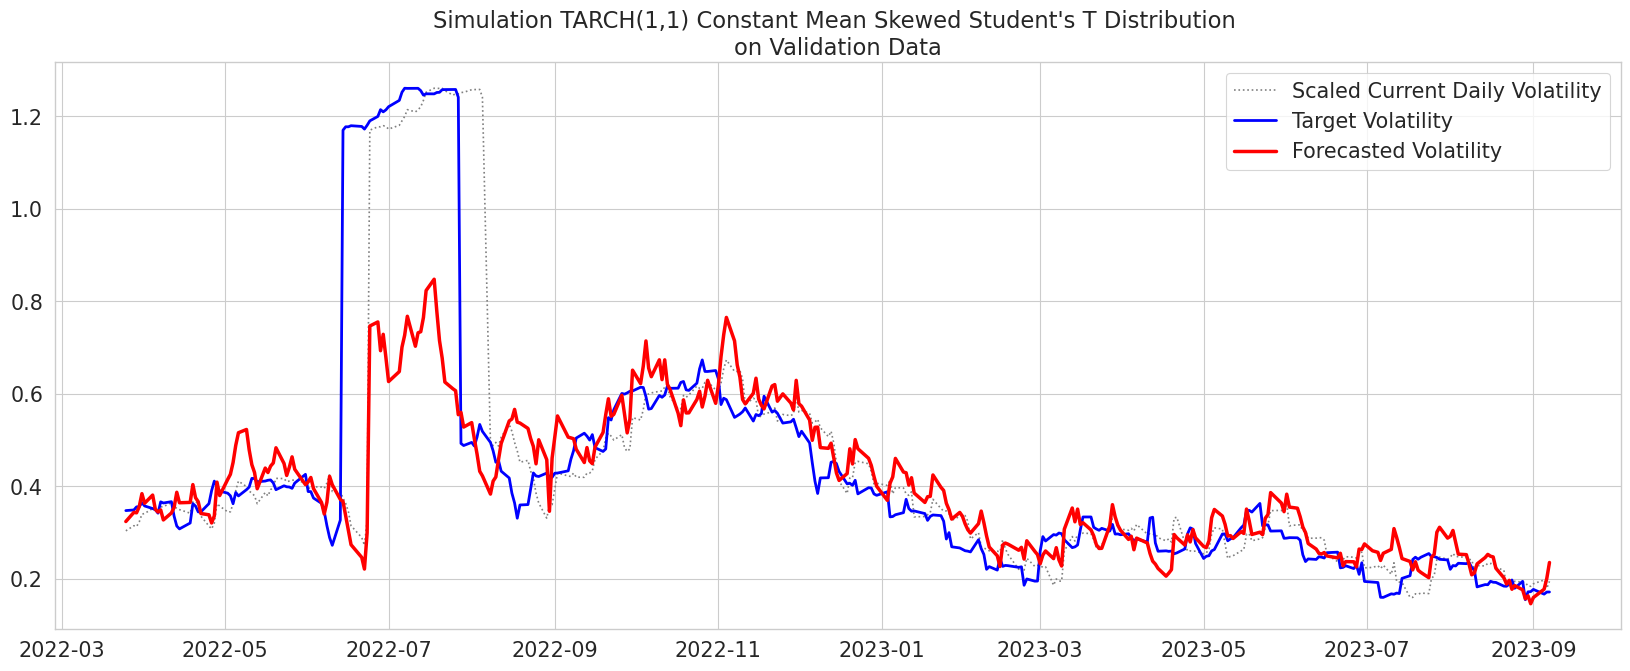

In [71]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [72]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.239770   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904  
5         0.191769

In [73]:
import itertools

In [74]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [75]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.23228387322341237 using TARCH(2, 2, 1)


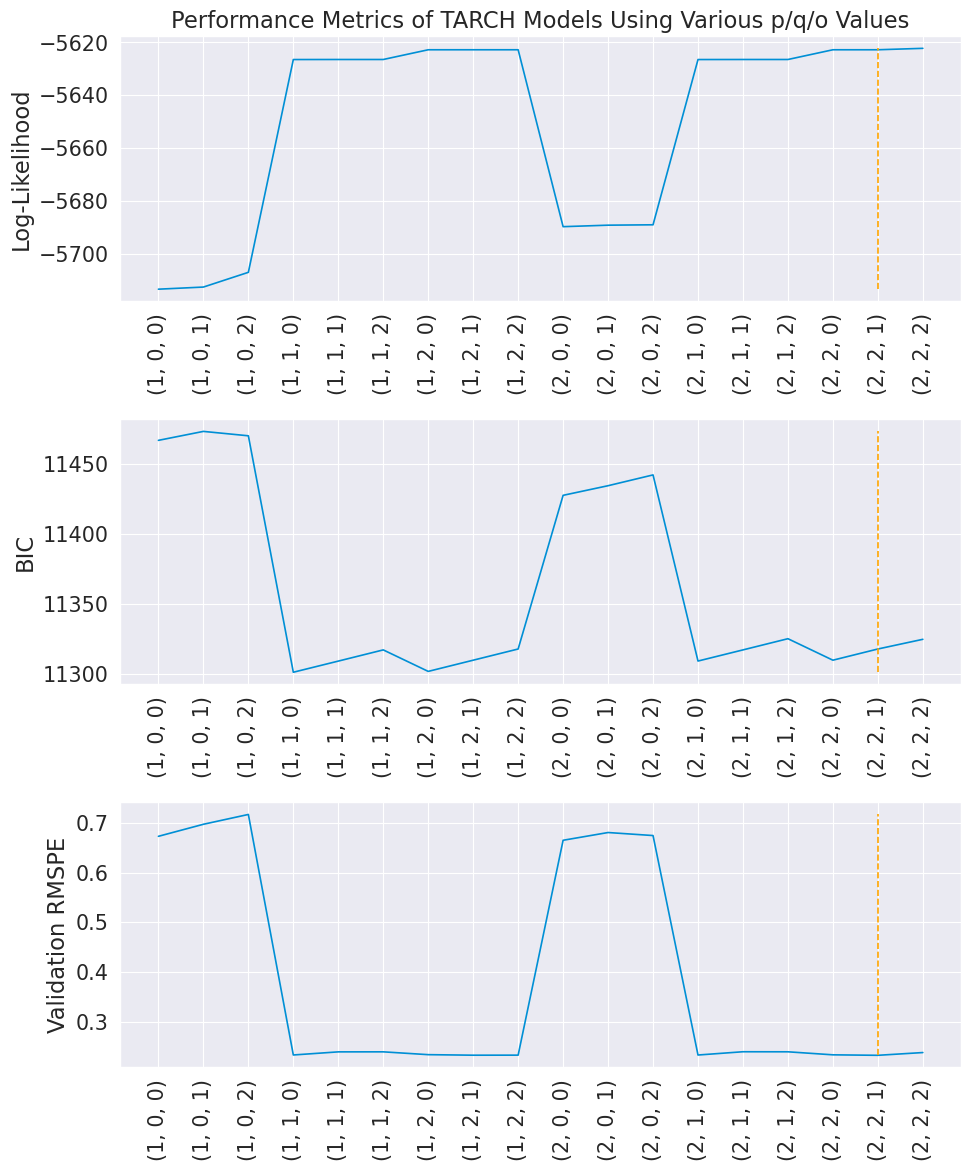

In [76]:
best_pqo = pqo_s[np.argmin(rmspe_s)]
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();

In [77]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -5622.76
Distribution:      Standardized Skew Student's t   AIC:                           11263.5
Method:                       Maximum Likelihood   BIC:                           11317.7
                                                   No. Observations:                 3045
Date:                           Mon, Nov 06 2023   Df Residuals:                     3044
Time:                                   22:45:34   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [78]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

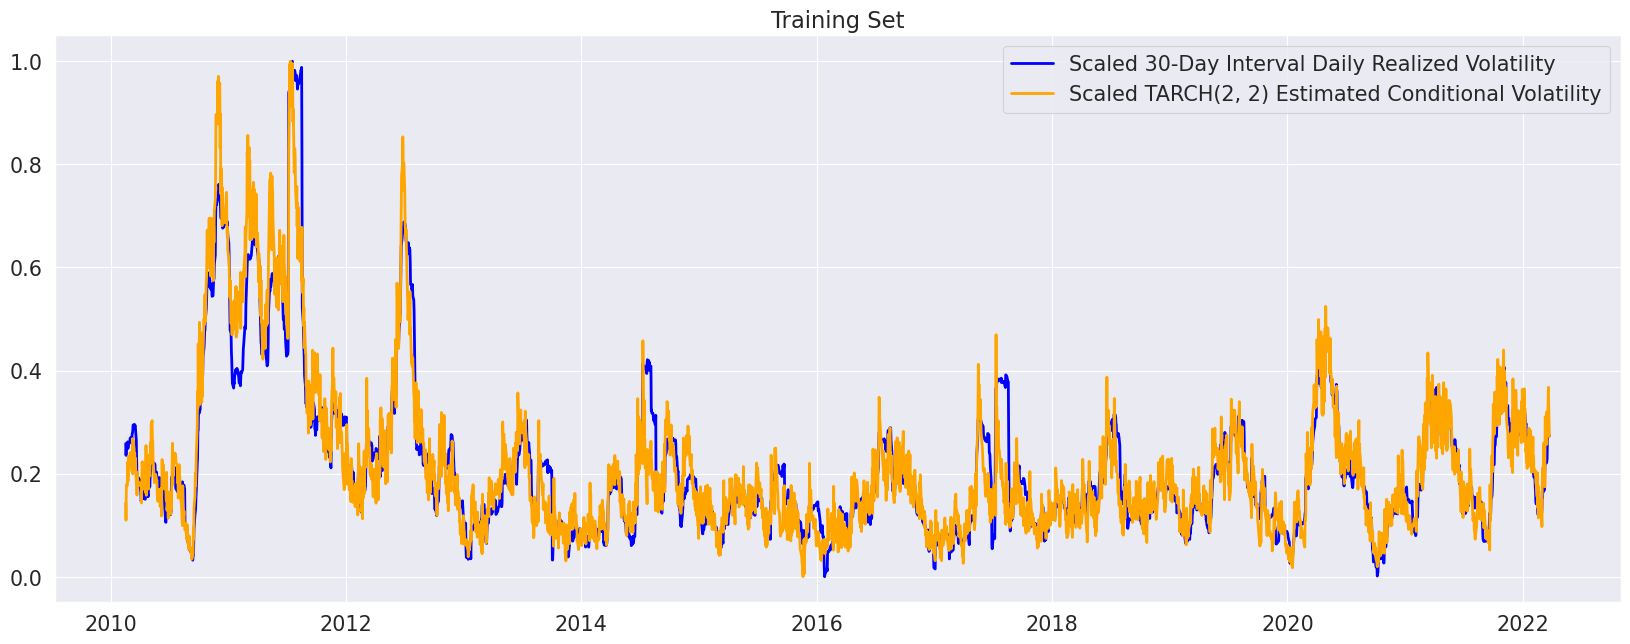

In [79]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [80]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [81]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

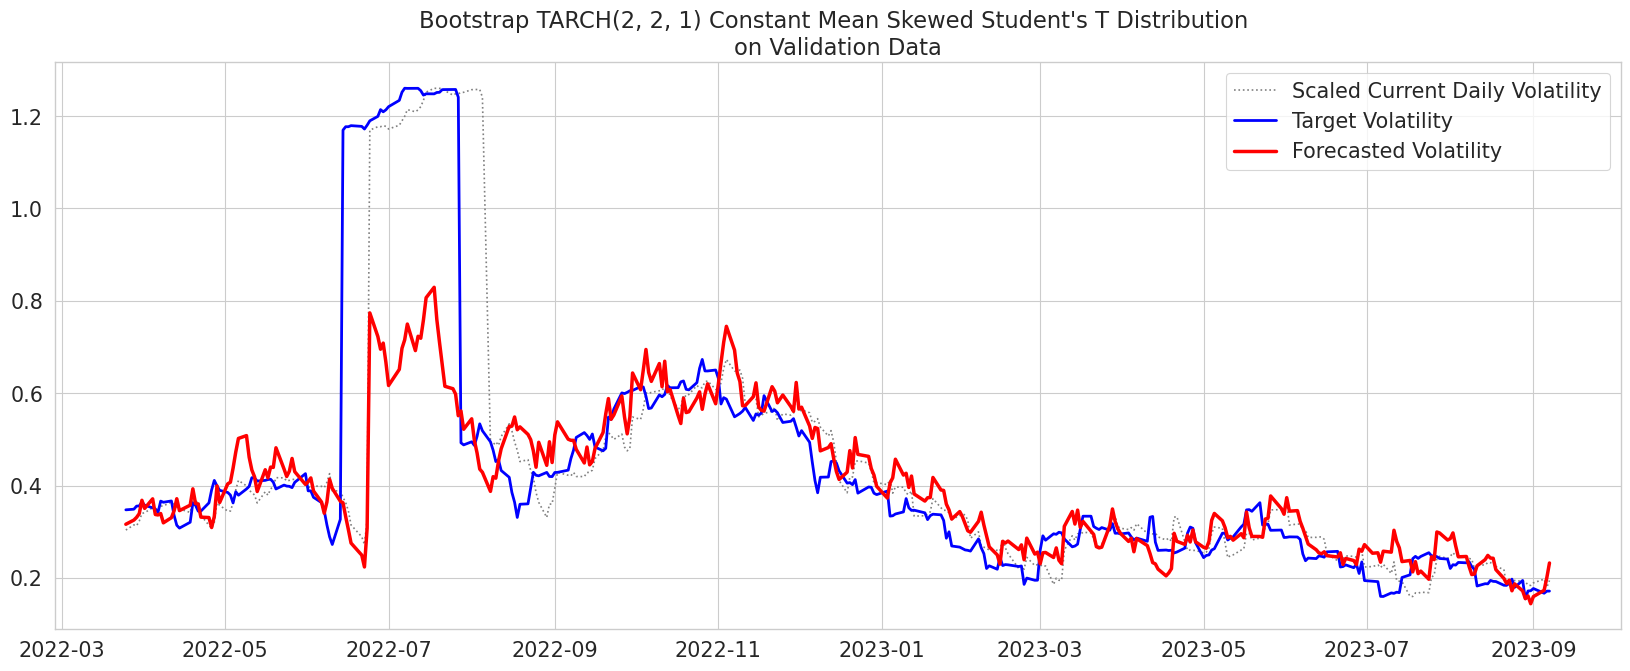

In [82]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")

plt.show();

In [83]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.239770   
6     Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist          0.232137   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904  
5         0.191769  
6         0.192078

# Networks

In [84]:
# !pip uninstall tensorflow
# !pip install tensorflow-intel==2.13.0 -U
# !pip freeze|findstr tensorflow
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

2023-11-06 22:46:00.923191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 22:46:01.209391: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 22:46:01.210915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 22:46:02.017721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [85]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [86]:
def rmspe(y_true, y_pred):

    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [87]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [88]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [89]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

# Neural Network Baseline Metrics - Fully Connected Network

In [90]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 3
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

print(x_train)
# x_train.to_csv('x_train.csv')
print(y_train)
# y_train.to_csv('y_train.csv')

print(len(val_idx))

# x_train = x_train.fillna(0)
# y_train = y_train.fillna(0)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Date
2010-02-17 00:00:00-05:00    0.017992
2010-02-18 00:00:00-05:00    0.017075
2010-02-19 00:00:00-05:00    0.017584
2010-02-22 00:00:00-05:00    0.018083
2010-02-23 00:00:00-05:00    0.018127
                               ...   
2022-03-18 00:00:00-04:00    0.018300
2022-03-21 00:00:00-04:00    0.018814
2022-03-22 00:00:00-04:00    0.018735
2022-03-23 00:00:00-04:00    0.018591
2022-03-24 00:00:00-04:00    0.018602
Name: vol_current, Length: 3045, dtype: float64
Date
2010-02-17 00:00:00-05:00    0.017979
2010-02-18 00:00:00-05:00    0.018027
2010-02-19 00:00:00-05:00    0.018232
2010-02-22 00:00:00-05:00    0.018426
2010-02-23 00:00:00-05:00    0.018453
                               ...   
2022-03-18 00:00:00-04:00    0.020202
2022-03-21 00:00:00-04:00    0.020607
2022-03-22 00:00:00-04:00    0.021284
2022-03-23 00:00:00-04:00    0.021341
2022-03-24 00:00:00-04:00    0.021776
Name: vol_future, Length: 3045, dtype: float64
365
Model: "sequential"
___________________________________

2023-11-06 22:46:03.048332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 22:46:03.048836: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [91]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

In [92]:
print(y_train)

Date
2010-02-17 00:00:00-05:00    0.017979
2010-02-18 00:00:00-05:00    0.018027
2010-02-19 00:00:00-05:00    0.018232
2010-02-22 00:00:00-05:00    0.018426
2010-02-23 00:00:00-05:00    0.018453
                               ...   
2022-03-18 00:00:00-04:00    0.020202
2022-03-21 00:00:00-04:00    0.020607
2022-03-22 00:00:00-04:00    0.021284
2022-03-23 00:00:00-04:00    0.021341
2022-03-24 00:00:00-04:00    0.021776
Name: vol_future, Length: 3045, dtype: float64


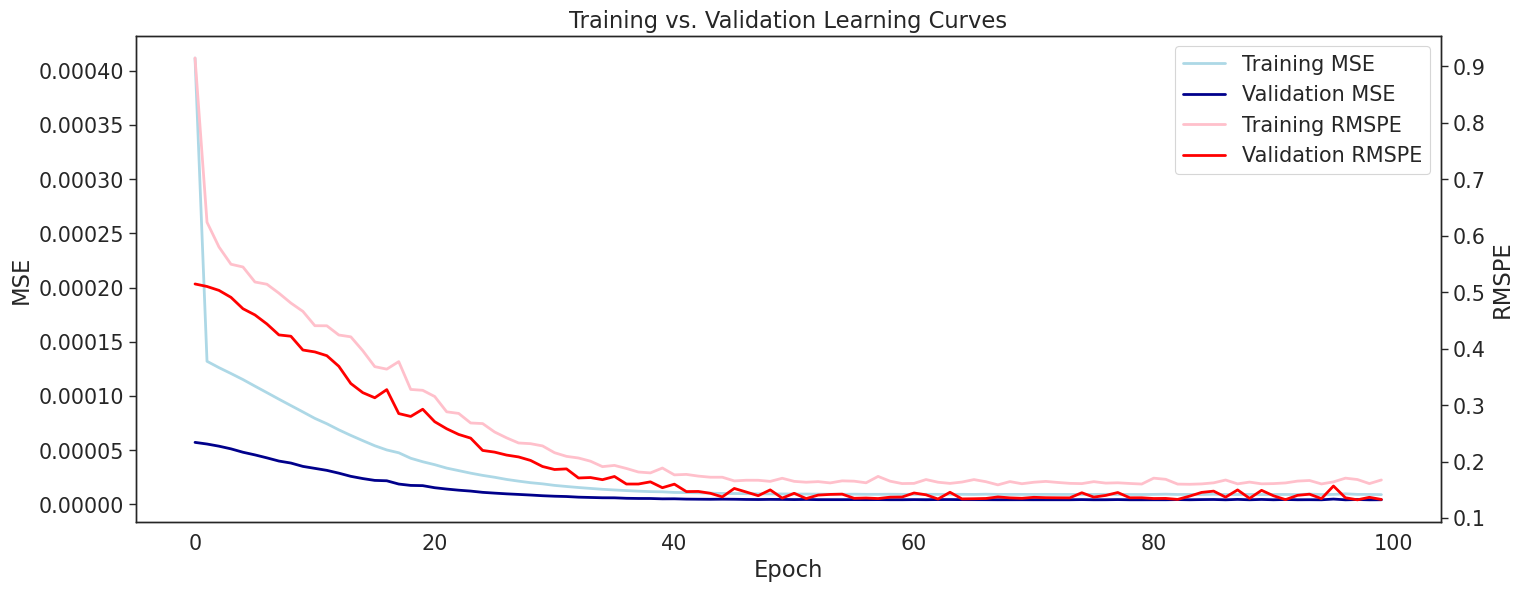

In [93]:
viz_train_val_metrics(snn_1_res)

In [94]:
# FORECASTING ON VALIDATION SET
# print(val_idx)
# print(train_idx)
# print(snn_1)
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 414us/step


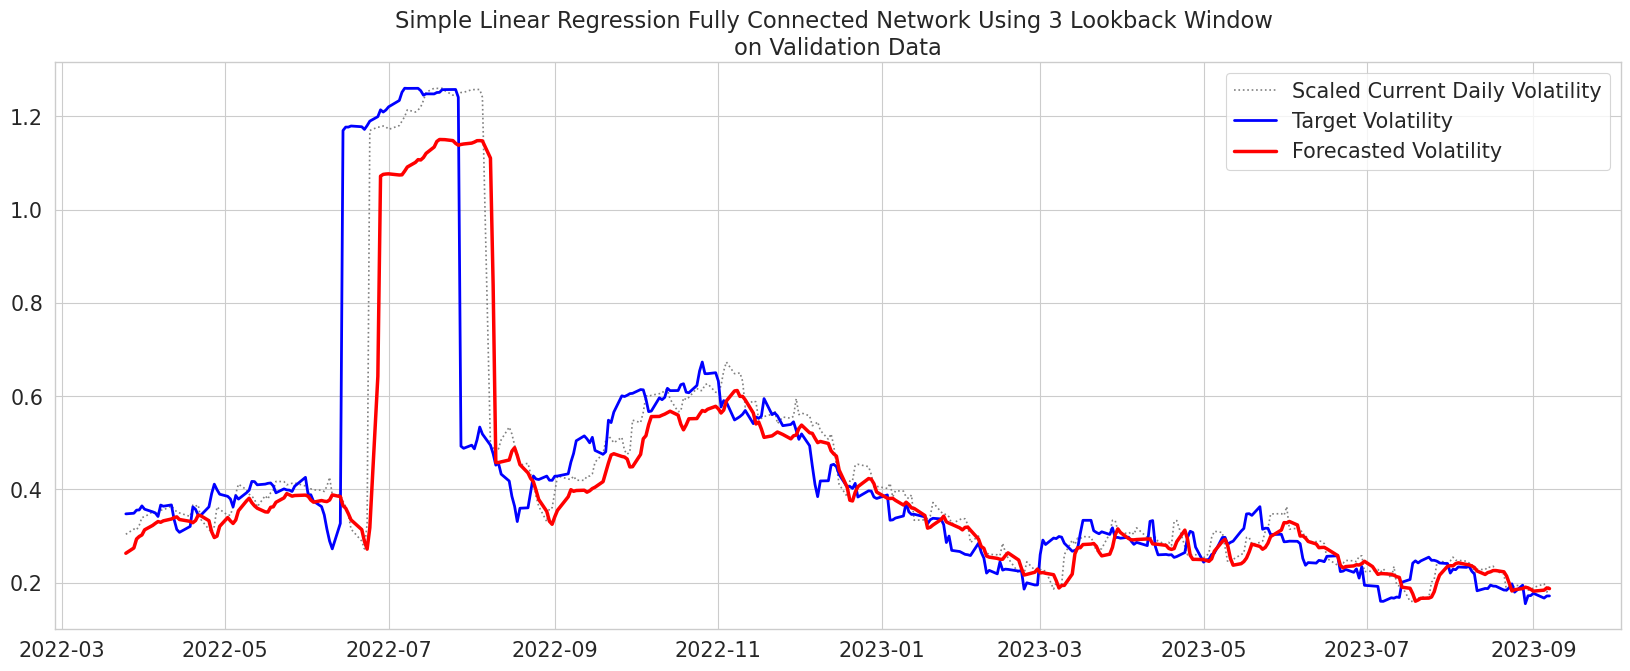

In [95]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [96]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.239770   
6     Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist          0.232137   
7                  Simple LR Fully Connected NN, n_past=3          0.264820   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904  
5         0.191769  
6         0.192078  
7         0.172304

# Univariate Long Short-Term Memory (LSTM)

In [97]:
!pip freeze| findstr tensorflow
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 3
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

/bin/bash: findstr: command not found
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [98]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

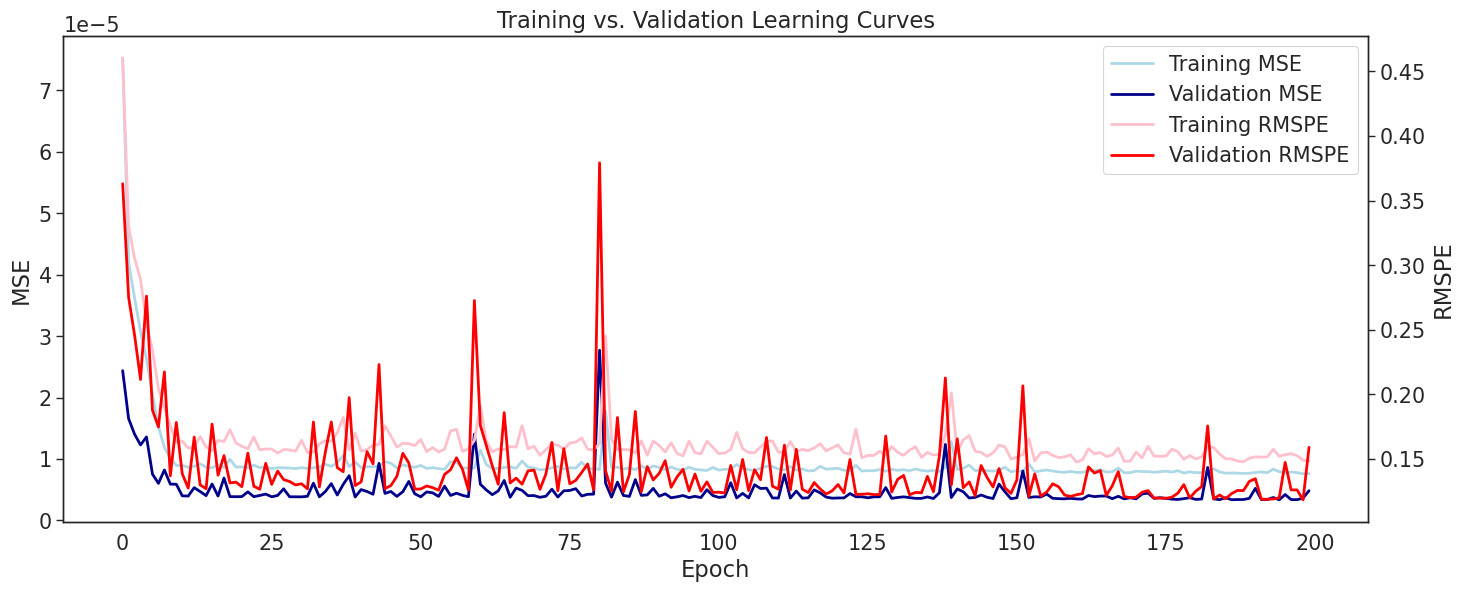

In [99]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [100]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 0s 784us/step


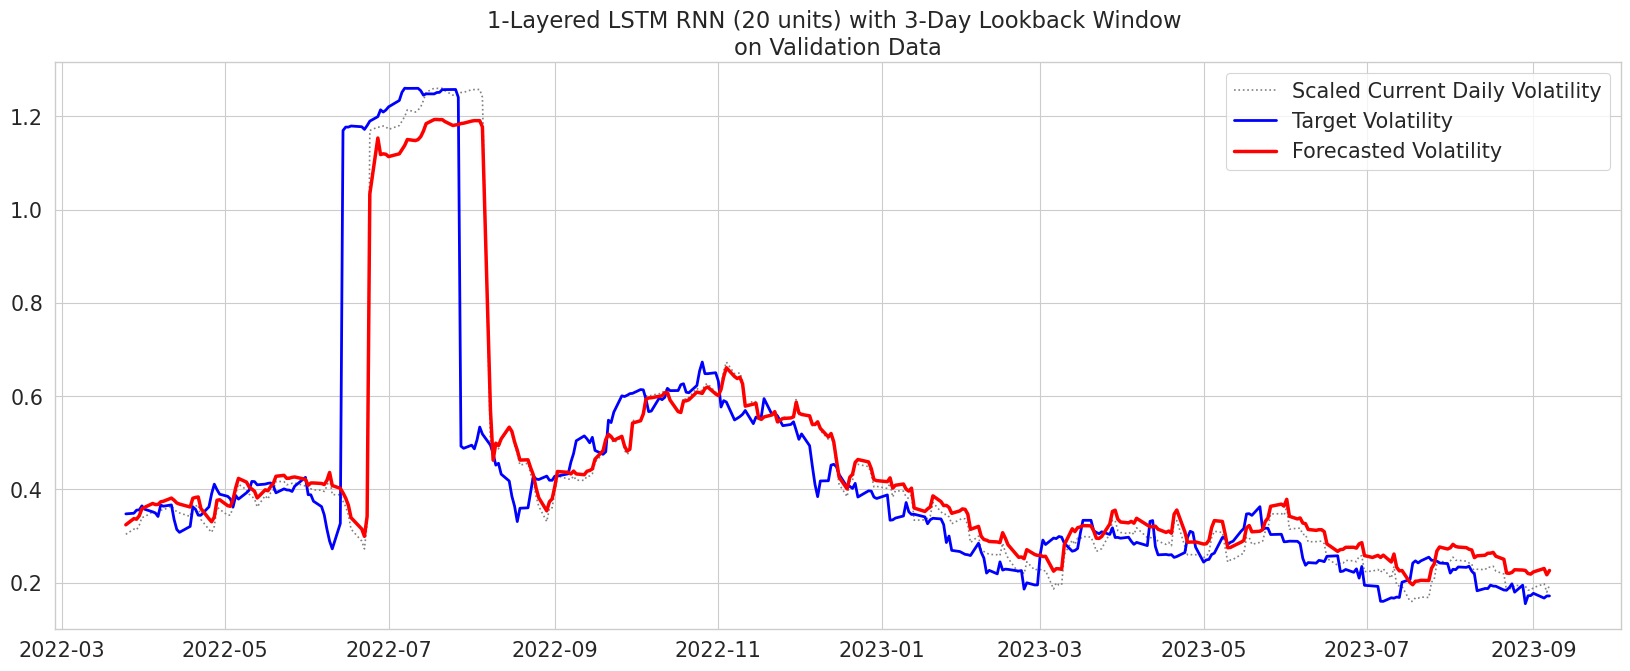

In [101]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

plt.show();

In [102]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.239770   
6     Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist          0.232137   
7                  Simple LR Fully Connected NN, n_past=3          0.264820   
8                         LSTM 1 layer 20 units, n_past=3          0.280994   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904  
5         0.191769  
6         0.192078  
7         0.172304  
8         0.159221

# Univariate Bidirectional LSTM

In [103]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 3
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19105 (74.63 KB)
Trainable params: 19105 (74.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [104]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

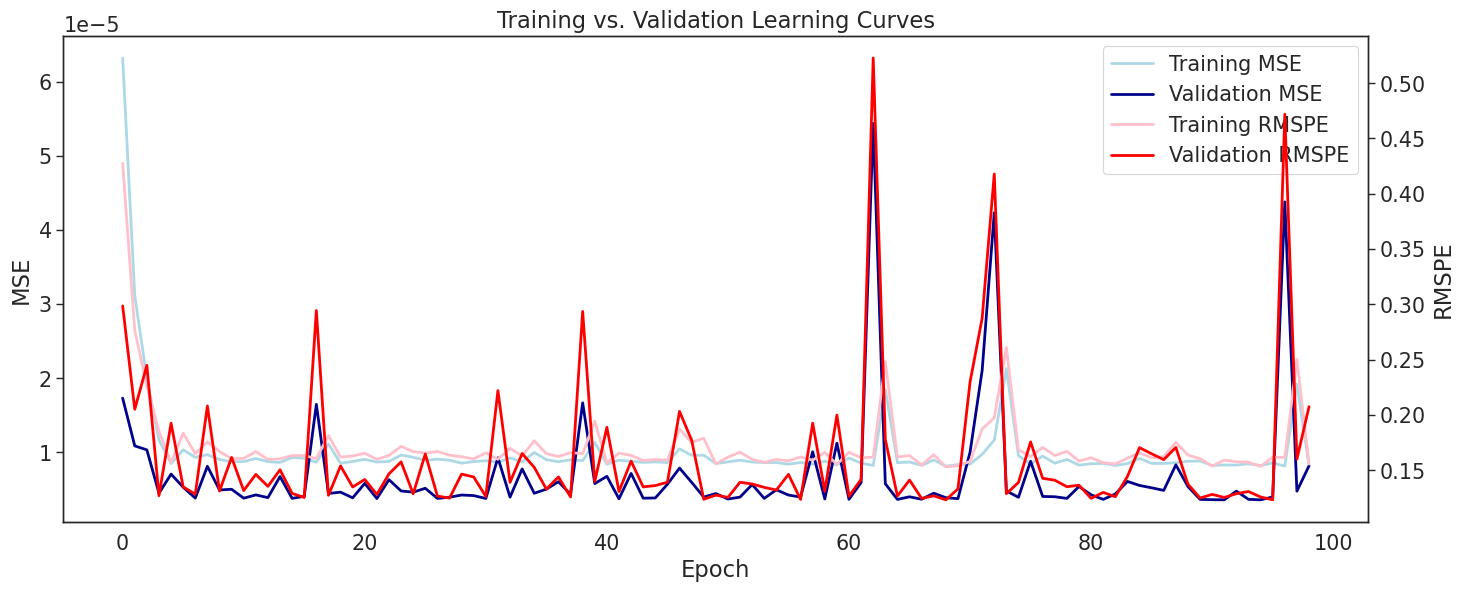

In [105]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [106]:

# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 1s 1ms/step


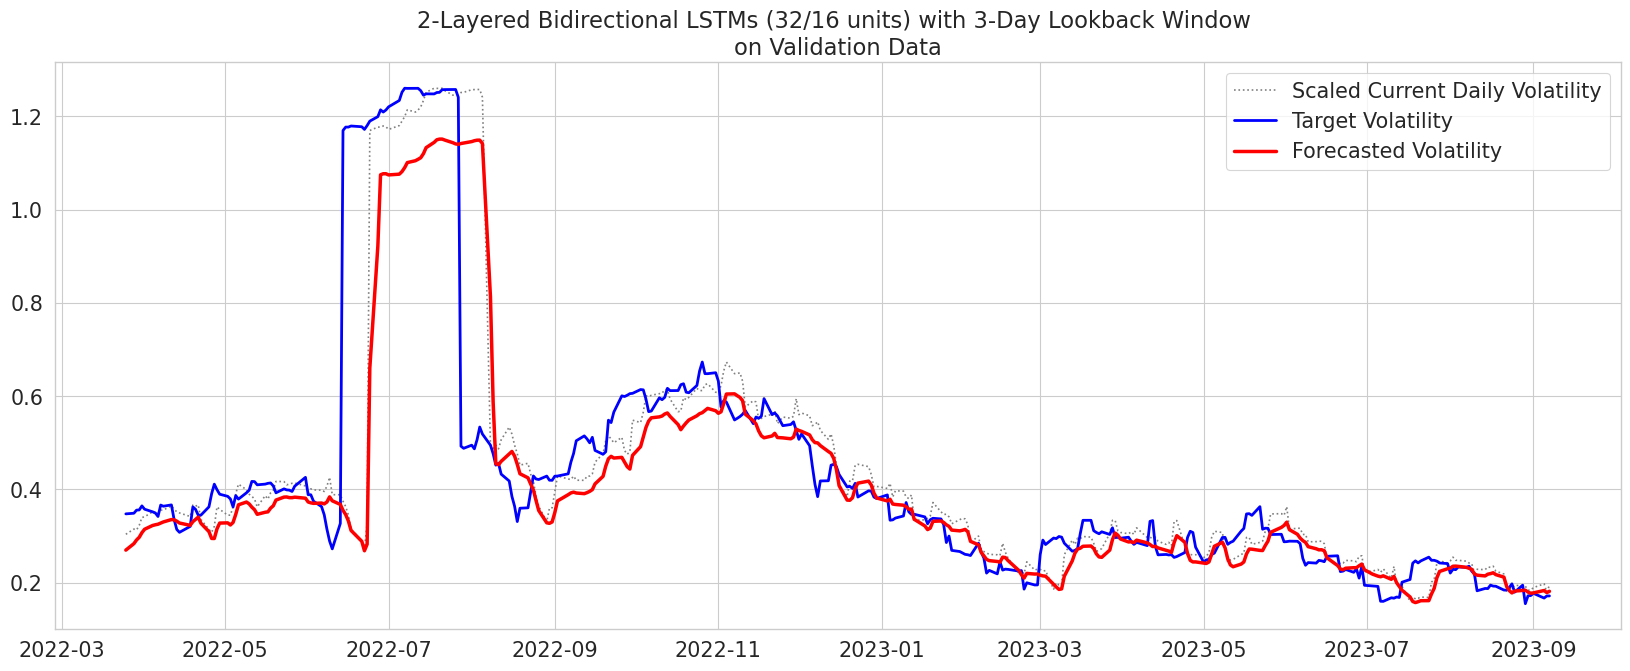

In [107]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

plt.show();

In [108]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.456495   
1                           Random Walk Naive Forecasting          0.271457   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.286458   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.287416   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.239530   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.239770   
6     Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist          0.232137   
7                  Simple LR Fully Connected NN, n_past=3          0.264820   
8                         LSTM 1 layer 20 units, n_past=3          0.280994   
9          2 layers Bidirect LSTM (32/16 units), n_past=3          0.250677   

   Validation RMSE  
0         0.345204  
1         0.164036  
2         0.182267  
3         0.194658  
4         0.191904  
5         0.191769  
6         0.192078  
7         0.172304  
8         0.159221  
9         0.164278

# Univariate Bidirectional LSTM + 1D Convolutional Layer(s)

In [109]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 4
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 

In [110]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

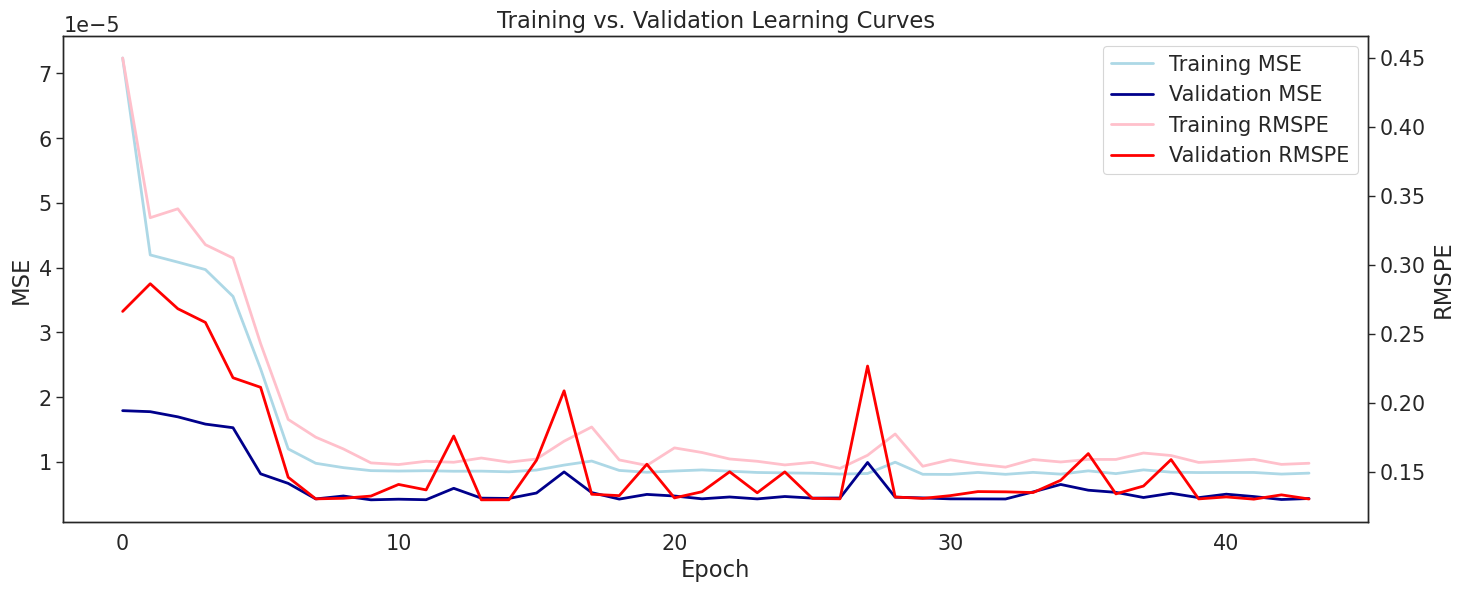

In [111]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [112]:
print(lstm_3)

In [113]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 0s 809us/step


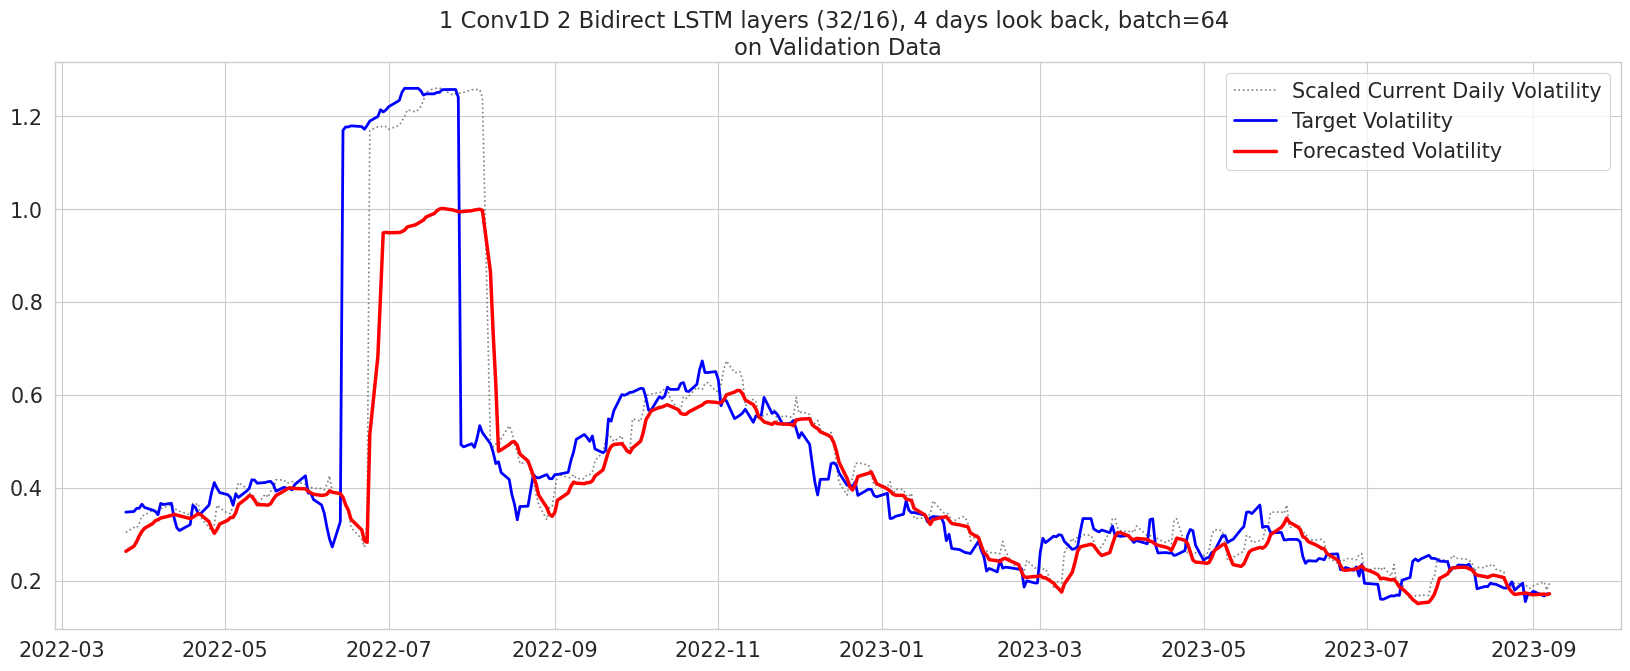

In [114]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.show();

In [115]:
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                 Mean Baseline   
1                                 Random Walk Naive Forecasting   
2                        GARCH(1,1), Constant Mean, Normal Dist   
3        Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4               Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5              Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6           Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                        Simple LR Fully Connected NN, n_past=3   
8                               LSTM 1 layer 20 units, n_past=3   
9                2 layers Bidirect LSTM (32/16 units), n_past=3   
10  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152

# Learning Rate Tuning with SGD Optimizer

In [116]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE 
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

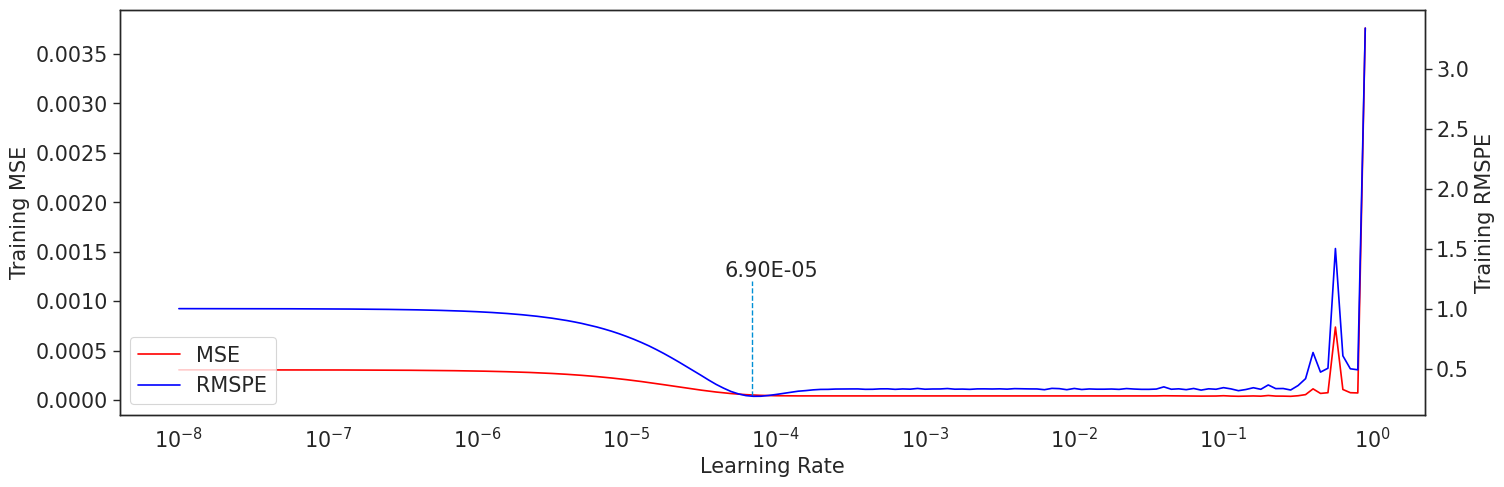

In [117]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 6.9e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

In [118]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

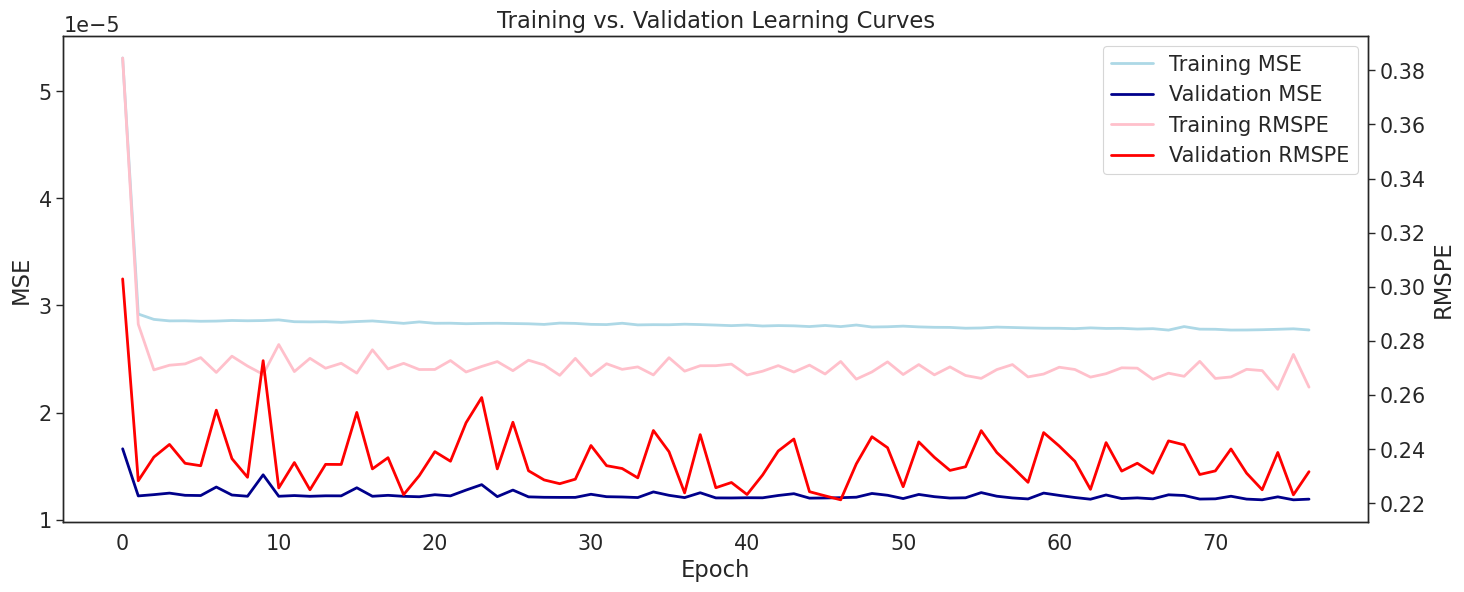

In [119]:
viz_train_val_metrics(lstm_4_res)

In [120]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

12/12 [==============================] - 1s 1ms/step


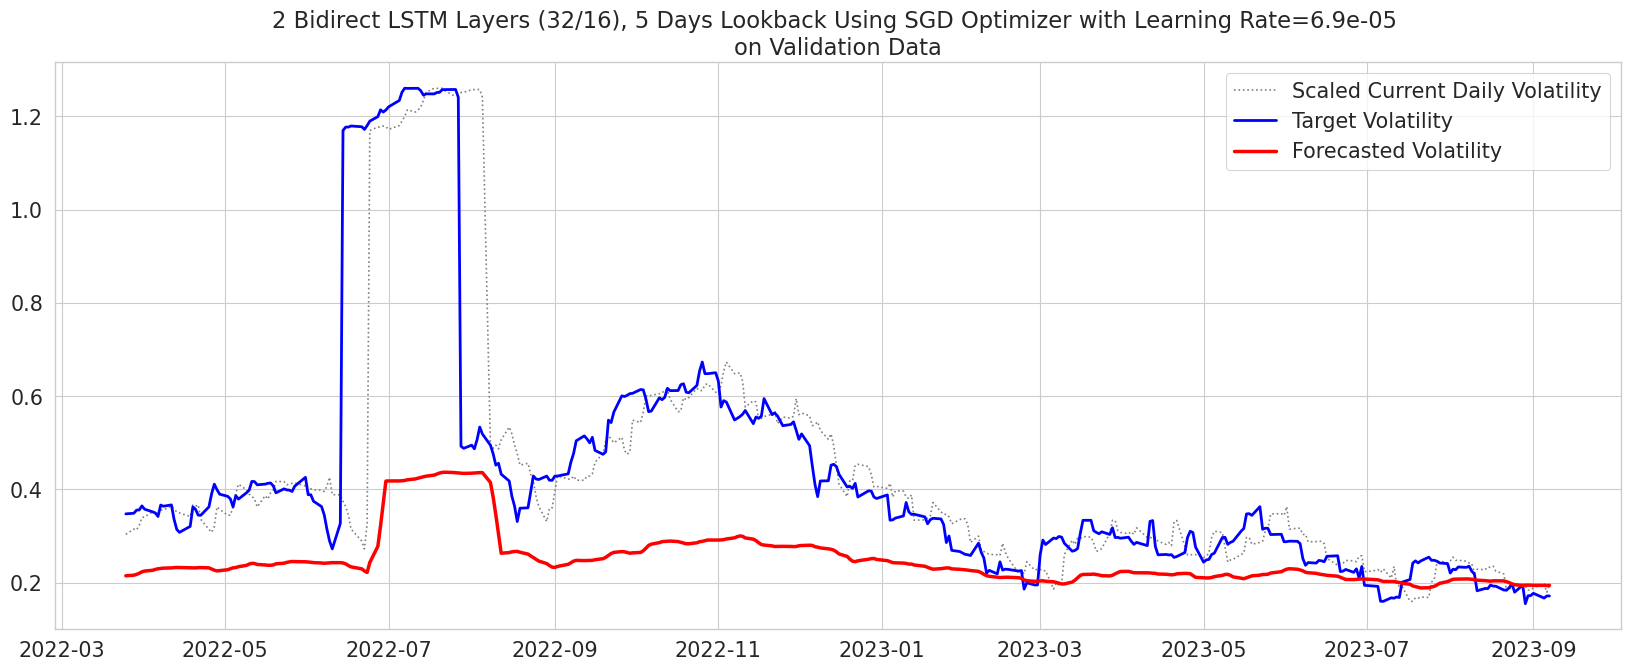

In [121]:
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")

plt.show();

In [150]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

Model  \
0                                                  Mean Baseline   
1                                  Random Walk Naive Forecasting   
2                         GARCH(1,1), Constant Mean, Normal Dist   
3         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6            Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=3   
8                                LSTM 1 layer 20 units, n_past=3   
9                 2 layers Bidirect LSTM (32/16 units), n_past=3   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
12  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152  
11          0.378170         0.289242  
12          0.378170         0.289242

# Multivariate LSTM

In [151]:
df.head()

Open       High        Low      Close  Volume  \
Date                                                                            
2010-02-17 00:00:00-05:00  75.000000  75.639999  74.760002  75.169998     NaN   
2010-02-18 00:00:00-05:00  75.150002  78.000000  74.730003  76.970001     NaN   
2010-02-19 00:00:00-05:00  76.470001  79.870003  76.309998  78.790001     NaN   
2010-02-22 00:00:00-05:00  79.300003  80.889999  78.790001  80.739998     NaN   
2010-02-23 00:00:00-05:00  80.720001  80.959999  79.559998  80.000000     NaN   

                            returns  log_returns  vol_current  vol_future  \
Date                                                                        
2010-02-17 00:00:00-05:00 -0.225641    -0.002259     0.017992    0.017979   
2010-02-18 00:00:00-05:00  2.394576     0.023664     0.017075    0.018027   
2010-02-19 00:00:00-05:00  2.364557     0.023370     0.017584    0.018232   
2010-02-22 00:00:00-05:00  2.474929     0.024448     0.018083    0.018426   
2010-02-23 00:00:00-05:00 -0.916520    -0.009207     0.018127    0.018453   

                            HL_sprd   CO_sprd  
Date                                           
2010-02-17 00:00:00-05:00 -4.447589  0.002267  
2010-02-18 00:00:00-05:00 -3.158627  0.024218  
2010-02-19 00:00:00-05:00 -3.097024  0.030339  
2010-02-22 00:00:00-05:00 -3.649297  0.018159  
2010-02-23 00:00:00-05:00 -4.045553 -0.008920

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3440 entries, 2010-02-17 00:00:00-05:00 to 2023-10-19 00:00:00-04:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3440 non-null   float64
 1   High         3440 non-null   float64
 2   Low          3440 non-null   float64
 3   Close        3440 non-null   float64
 4   Volume       3440 non-null   int64  
 5   returns      3440 non-null   float64
 6   log_returns  3440 non-null   float64
 7   vol_current  3440 non-null   float64
 8   vol_future   3440 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 397.8 KB


In [194]:
df['HL_sprd'] = (((df.High - df.Low) / df.Close))
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = df.Volume

In [126]:
# df['HL_sprd'] = (df.High - df.Low) / df.Close
# df['CO_sprd'] = (df.Close - df.Open) / df.Open
# df['Volume'] = (df.Volume)

In [186]:
df.head()

Open       High        Low      Close  Volume  \
Date                                                                            
2010-02-17 00:00:00-05:00  75.000000  75.639999  74.760002  75.169998    5950   
2010-02-18 00:00:00-05:00  75.150002  78.000000  74.730003  76.970001    7607   
2010-02-19 00:00:00-05:00  76.470001  79.870003  76.309998  78.790001    3506   
2010-02-22 00:00:00-05:00  79.300003  80.889999  78.790001  80.739998     646   
2010-02-23 00:00:00-05:00  80.720001  80.959999  79.559998  80.000000     255   

                            returns  log_returns  vol_current  vol_future  \
Date                                                                        
2010-02-17 00:00:00-05:00 -0.225641    -0.002259     0.017992    0.017979   
2010-02-18 00:00:00-05:00  2.394576     0.023664     0.017075    0.018027   
2010-02-19 00:00:00-05:00  2.364557     0.023370     0.017584    0.018232   
2010-02-22 00:00:00-05:00  2.474929     0.024448     0.018083    0.018426   
2010-02-23 00:00:00-05:00 -0.916520    -0.009207     0.018127    0.018453   

                            HL_sprd   CO_sprd  
Date                                           
2010-02-17 00:00:00-05:00 -4.447589  0.002267  
2010-02-18 00:00:00-05:00 -3.158627  0.024218  
2010-02-19 00:00:00-05:00 -3.097024  0.030339  
2010-02-22 00:00:00-05:00 -3.649297  0.018159  
2010-02-23 00:00:00-05:00 -4.045553 -0.008920

In [196]:
df.describe()

Open         High          Low        Close        Volume  \
count  3440.000000  3440.000000  3440.000000  3440.000000   3440.000000   
mean     84.230381    85.115753    83.366977    84.172392   9387.337500   
std      25.309192    25.901226    24.687834    25.252092   9882.920453   
min      48.950001    51.130001    48.349998    48.410000      0.000000   
25%      68.365002    68.887499    67.847498    68.290001     26.000000   
50%      79.559998    80.535000    78.760002    79.384998   8171.000000   
75%      88.184999    88.922499    87.382498    88.204998  16449.750000   
max     215.619995   227.000000   210.750000   215.149994  69381.000000   

           returns  log_returns  vol_current   vol_future      HL_sprd  \
count  3440.000000  3440.000000  3440.000000  3440.000000  3440.000000   
mean      0.019767     0.000033     0.017091     0.017080     0.019344   
std       1.804817     0.018246     0.007294     0.007296     0.014888   
min     -23.884979    -0.272925     0.007578     0.007578     0.000000   
25%      -0.874448    -0.008783     0.012543     0.012532     0.010359   
50%       0.000000     0.000000     0.014969     0.014943     0.016981   
75%       0.948466     0.009440     0.019315     0.019315     0.026268   
max       7.212294     0.069641     0.058419     0.058419     0.310813   

           CO_sprd  
count  3440.000000  
mean     -0.000497  
std       0.015881  
min      -0.215425  
25%      -0.008249  
50%       0.000000  
75%       0.007442  
max       0.074039

In [188]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

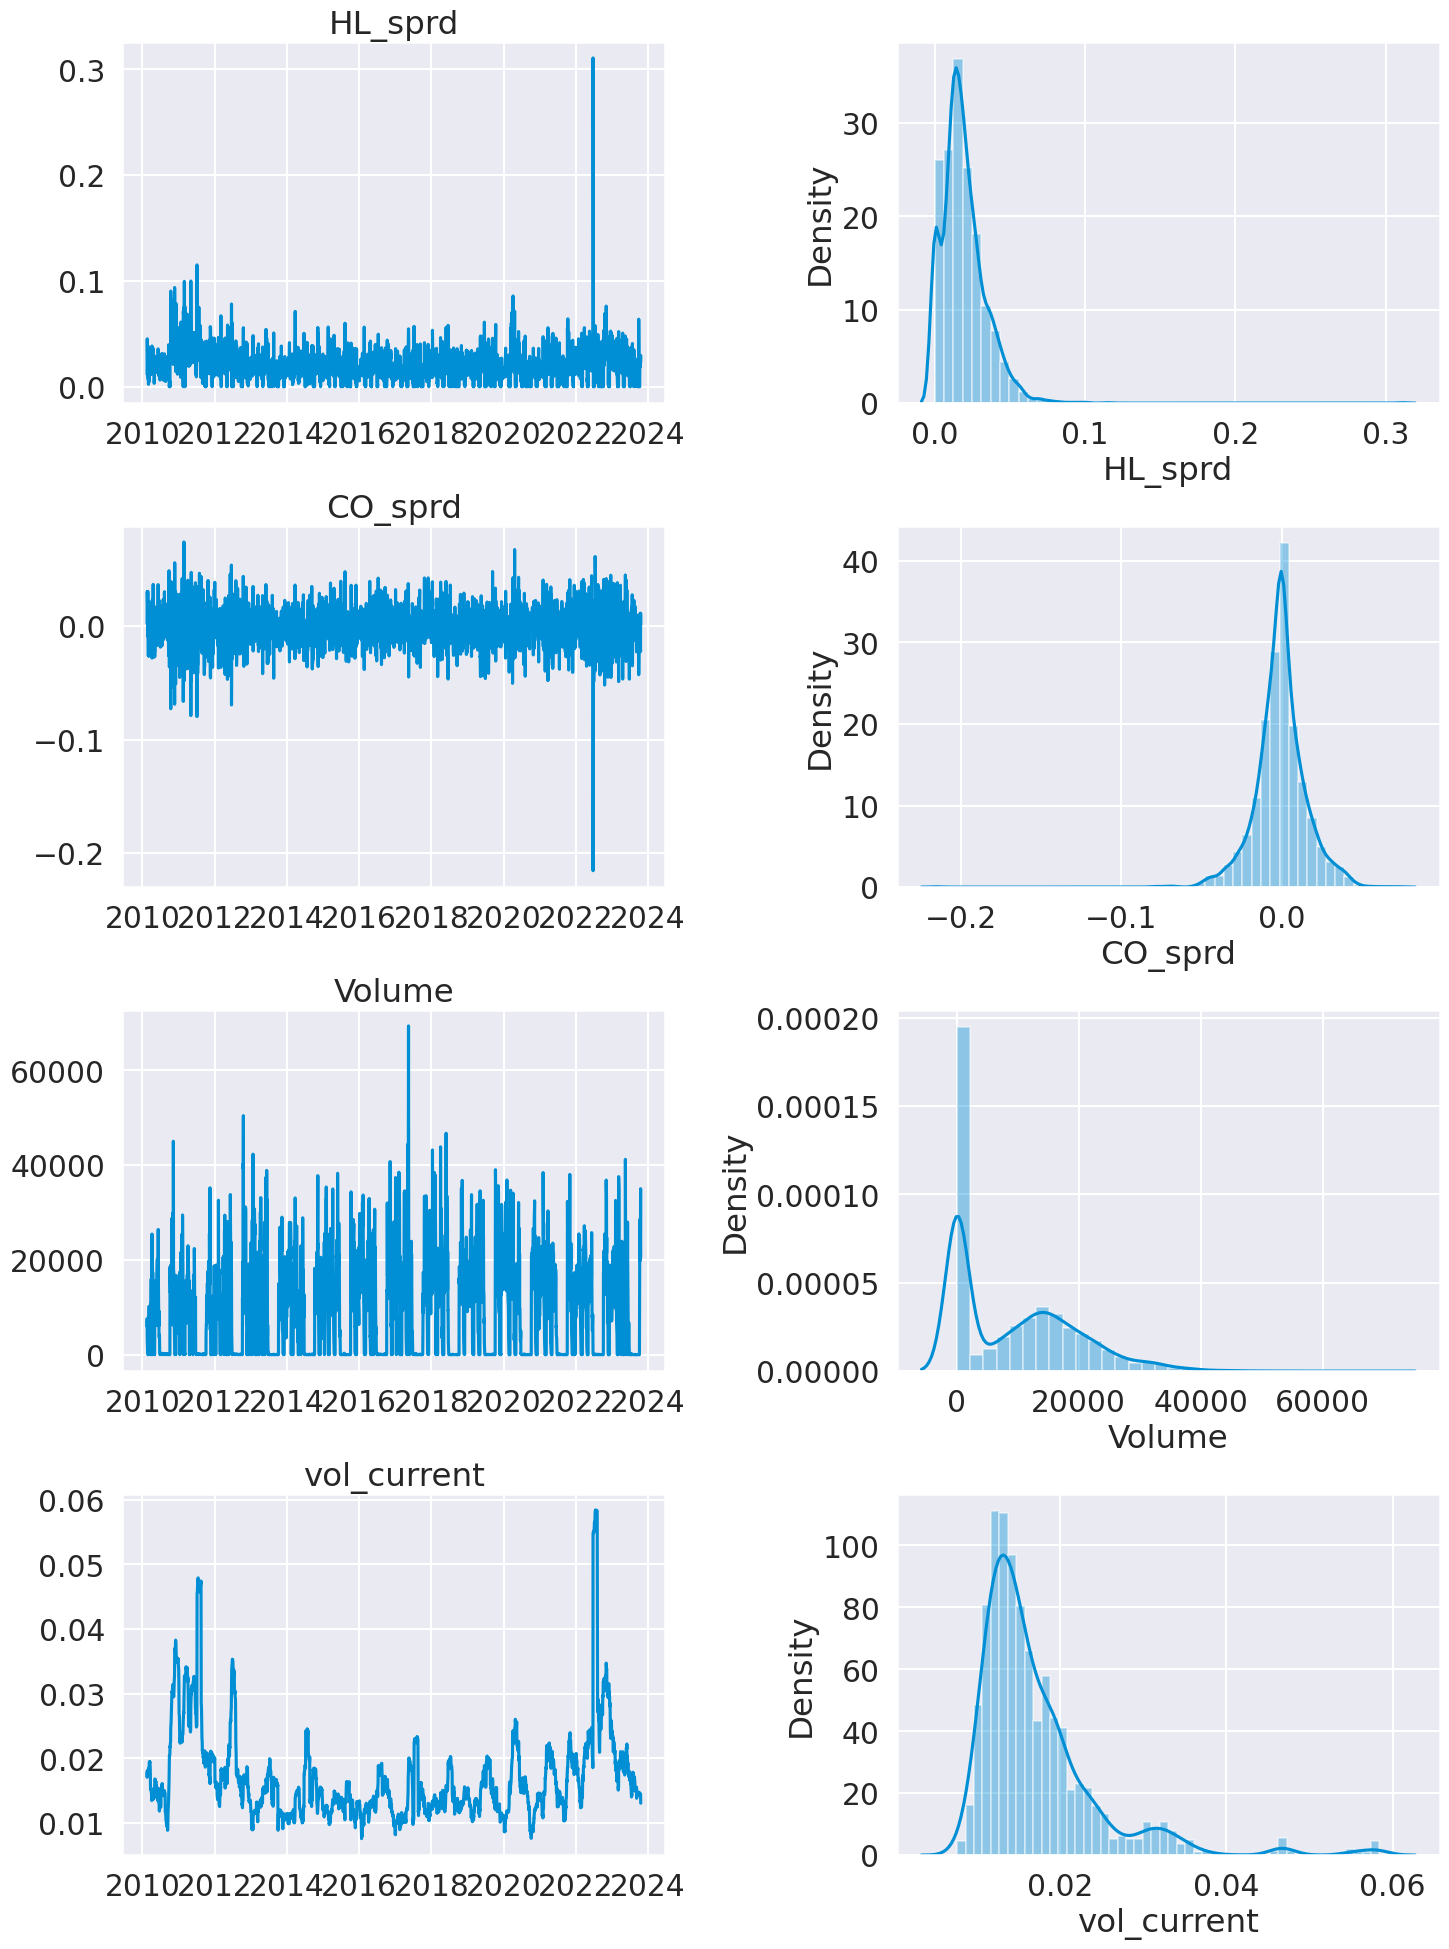

In [197]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'features.png'), 
    #             dpi=300, bbox_inches='tight')
    plt.show();

In [198]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [199]:
X_train.head()


HL_sprd   CO_sprd  Volume  vol_current
Date                                                              
2010-02-17 00:00:00-05:00  0.011707  0.002267    5950     0.017992
2010-02-18 00:00:00-05:00  0.042484  0.024218    7607     0.017075
2010-02-19 00:00:00-05:00  0.045183  0.030339    3506     0.017584
2010-02-22 00:00:00-05:00  0.026009  0.018159     646     0.018083
2010-02-23 00:00:00-05:00  0.017500 -0.008920     255     0.018127

In [200]:
input_df.head()


HL_sprd   CO_sprd  Volume  vol_current
Date                                                              
2010-02-17 00:00:00-05:00  0.011707  0.002267    5950     0.017992
2010-02-18 00:00:00-05:00  0.042484  0.024218    7607     0.017075
2010-02-19 00:00:00-05:00  0.045183  0.030339    3506     0.017584
2010-02-22 00:00:00-05:00  0.026009  0.018159     646     0.018083
2010-02-23 00:00:00-05:00  0.017500 -0.008920     255     0.018127

In [201]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3045 entries, 2010-02-17 00:00:00-05:00 to 2022-03-24 00:00:00-04:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3045 non-null   float64
 1   CO_sprd      3045 non-null   float64
 2   Volume       3045 non-null   int64  
 3   vol_current  3045 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 118.9 KB


In [202]:
input_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3440 entries, 2010-02-17 00:00:00-05:00 to 2023-10-19 00:00:00-04:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3440 non-null   float64
 1   CO_sprd      3440 non-null   float64
 2   Volume       3440 non-null   int64  
 3   vol_current  3440 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 263.4 KB


In [203]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [205]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5, 4)              16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 5, 64)             9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [206]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=1, batch_size=batch_size, epochs=200)

Epoch 1/200
38/38 [==============================] - 3s 23ms/step - loss: 5.5048e-04 - rmspe: 1.5427 - val_loss: 1.3216e-04 - val_rmspe: 0.8127
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 2.2280e-04 - rmspe: 0.9882 - val_loss: 2.7444e-05 - val_rmspe: 0.3815
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 1.4845e-04 - rmspe: 0.8199 - val_loss: 3.4214e-05 - val_rmspe: 0.4070
Epoch 4/200
38/38 [==============================] - 0s 4ms/step - loss: 9.9489e-05 - rmspe: 0.6765 - val_loss: 2.2022e-05 - val_rmspe: 0.2692
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 8.4016e-05 - rmspe: 0.5995 - val_loss: 2.3777e-05 - val_rmspe: 0.3257
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 6.9371e-05 - rmspe: 0.5502 - val_loss: 1.9011e-05 - val_rmspe: 0.2837
Epoch 7/200
38/38 [==============================] - 0s 5ms/step - loss: 6.1384e-05 - rmspe: 0.5090 - val_loss: 2.2189e-05 - val_rmspe: 0.246

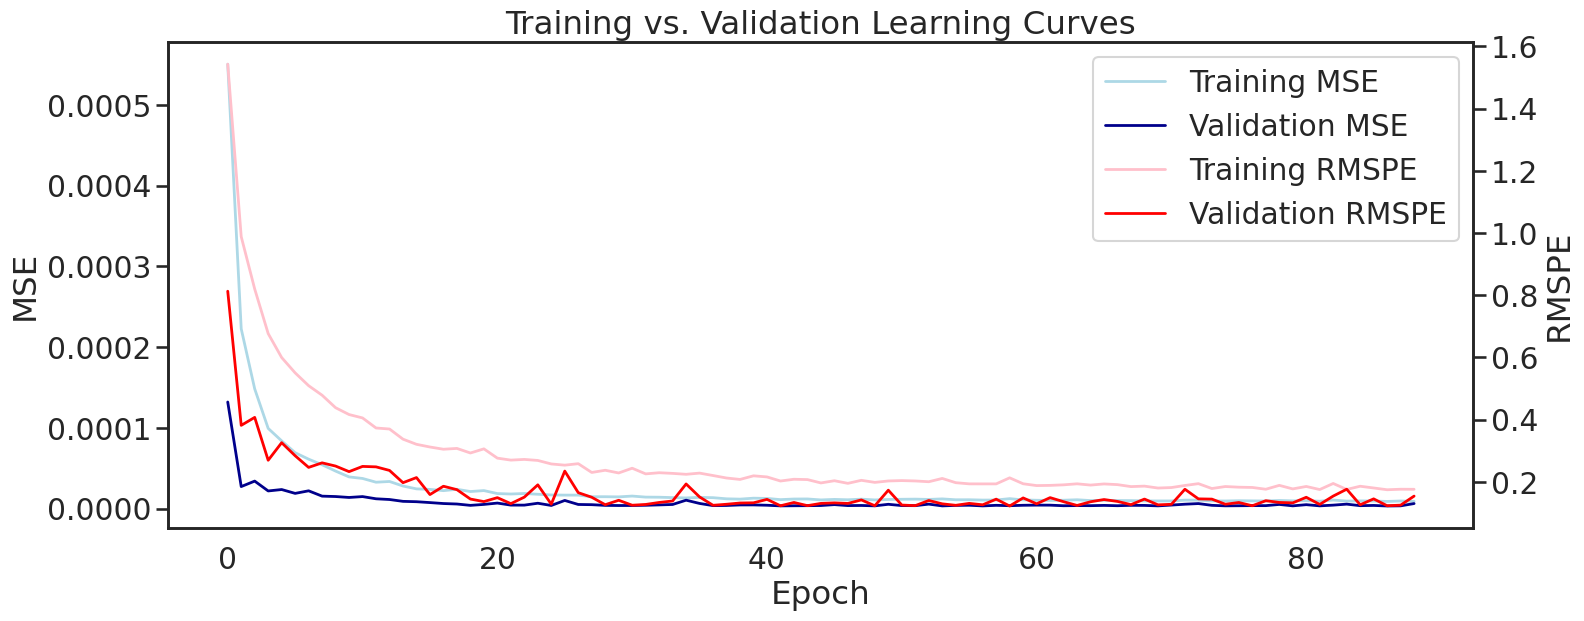

In [207]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [208]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 1s 1ms/step


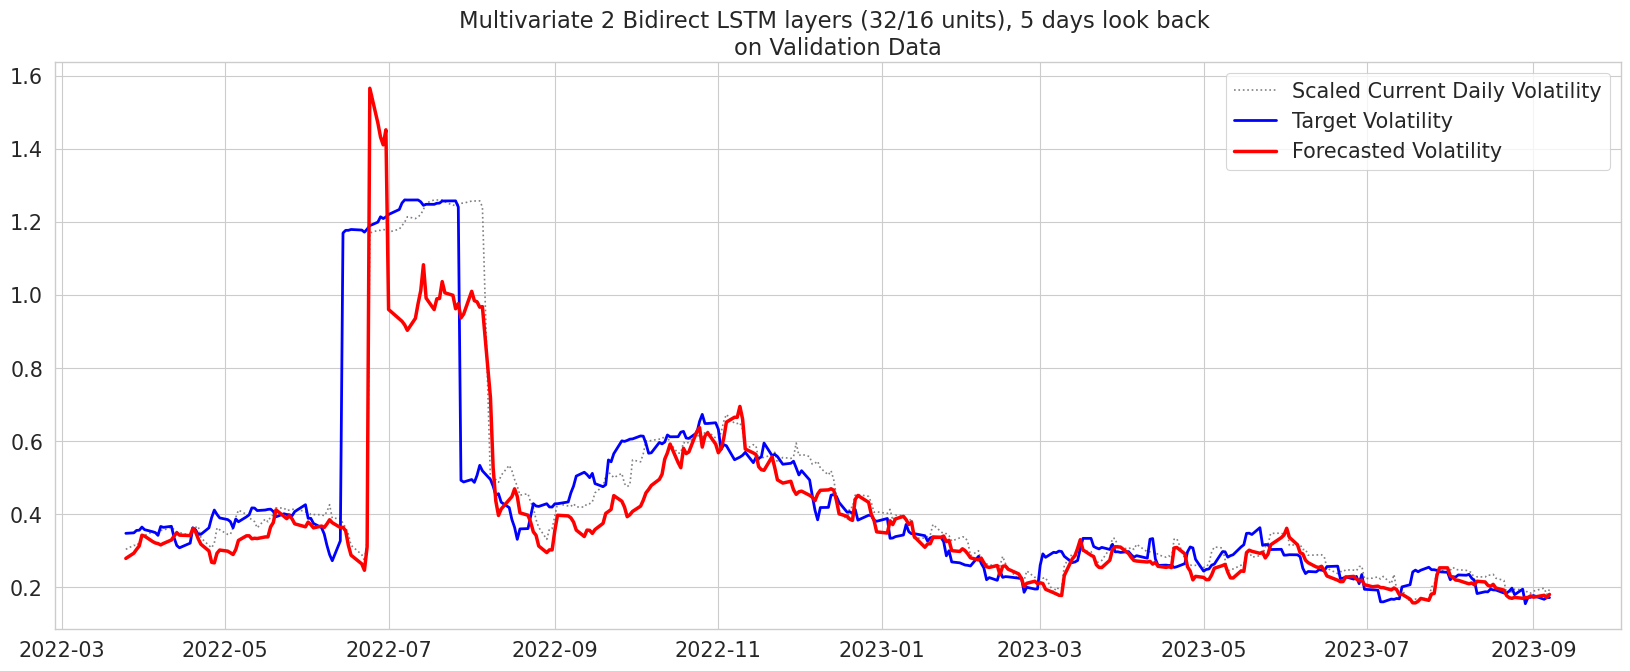

In [209]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
# plt.savefig(os.path.join(directory_to_img, 'lstm_5.png'), 
#             dpi=300, bbox_inch='tight')
plt.show();

In [210]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                  Mean Baseline   
1                                  Random Walk Naive Forecasting   
2                         GARCH(1,1), Constant Mean, Normal Dist   
3         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6            Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                         Simple LR Fully Connected NN, n_past=3   
8                                LSTM 1 layer 20 units, n_past=3   
9                 2 layers Bidirect LSTM (32/16 units), n_past=3   
10   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
12  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
13   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=5   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152  
11          0.378170         0.289242  
12          0.378170         0.289242  
13          0.229656         0.164826

In [212]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 
    
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5, 4)              16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 5, 128)            35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 64)             41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                        

In [213]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

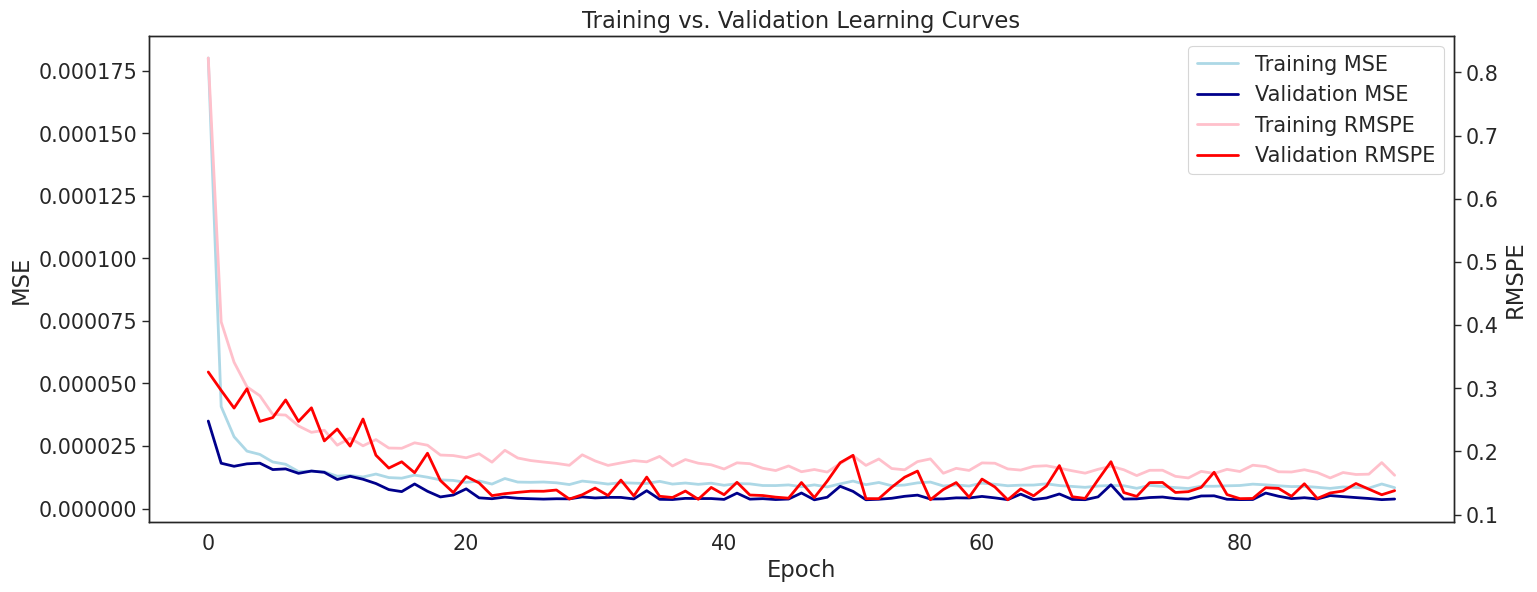

In [214]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [215]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 1s 2ms/step


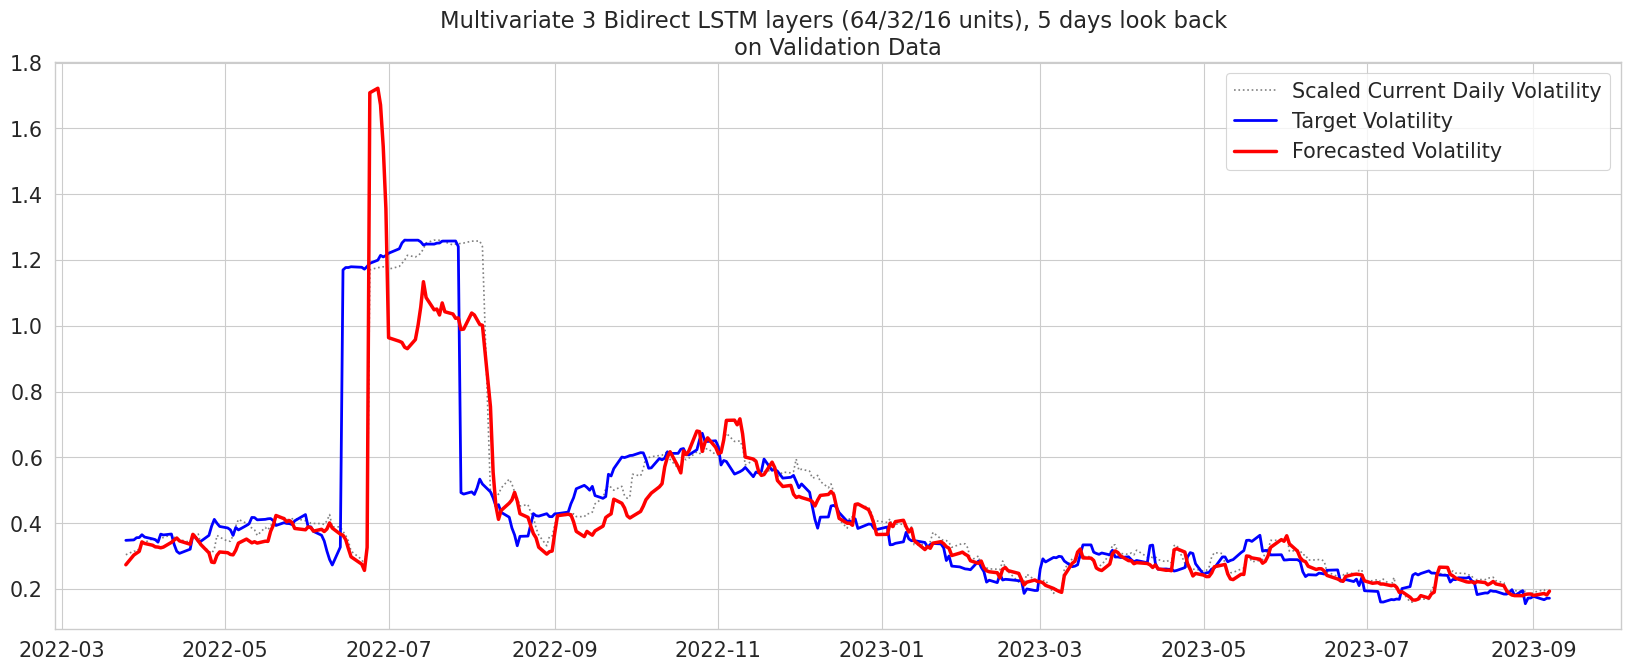

In [216]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")
# plt.savefig(os.path.join(directory_to_img, 'lstm_6.png'), 
#             dpi=300, bbox_inch='tight')
plt.show();

In [217]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  \
0                                                    Mean Baseline   
1                                    Random Walk Naive Forecasting   
2                           GARCH(1,1), Constant Mean, Normal Dist   
3           Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                  Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                 Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6              Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                           Simple LR Fully Connected NN, n_past=3   
8                                  LSTM 1 layer 20 units, n_past=3   
9                   2 layers Bidirect LSTM (32/16 units), n_past=3   
10     1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
11    2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
12    2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
13     Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=5   
14  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=5   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152  
11          0.378170         0.289242  
12          0.378170         0.289242  
13          0.229656         0.164826  
14          0.235314         0.166773

In [218]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5, 4)              16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 5, 256)            136192    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 128)            164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                        

In [219]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

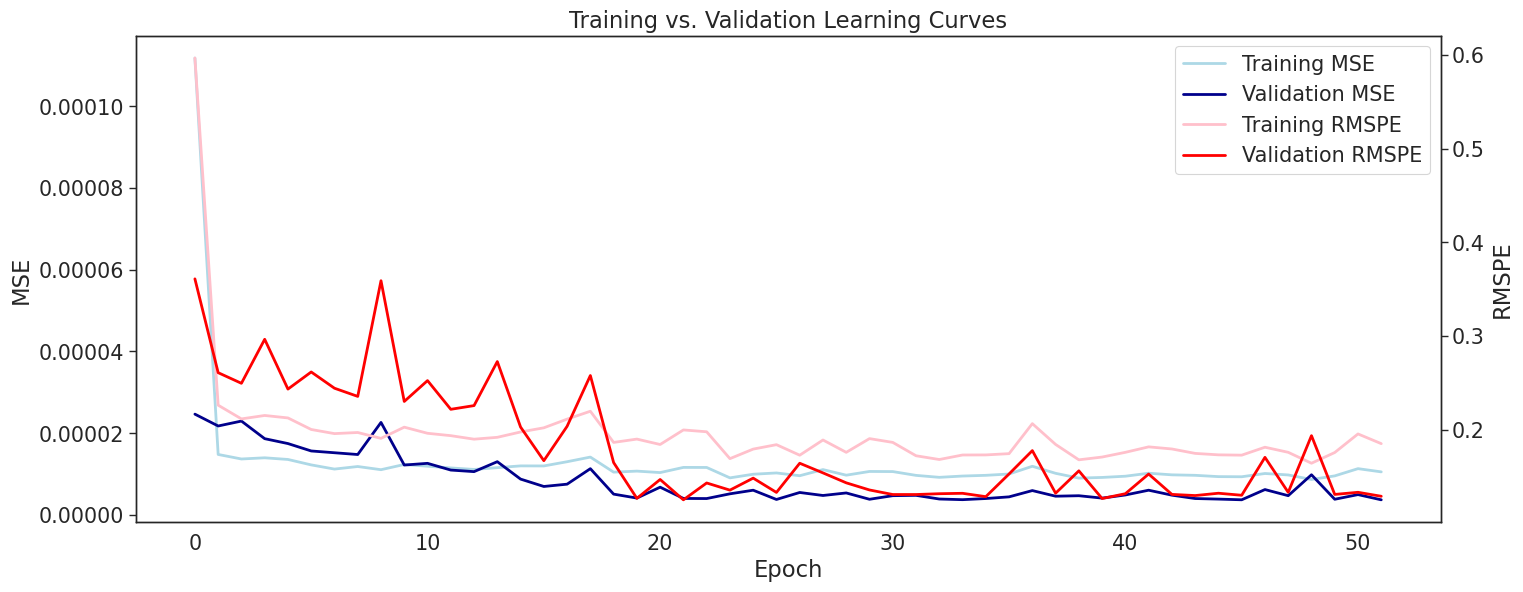

In [220]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)

In [221]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 1s 3ms/step


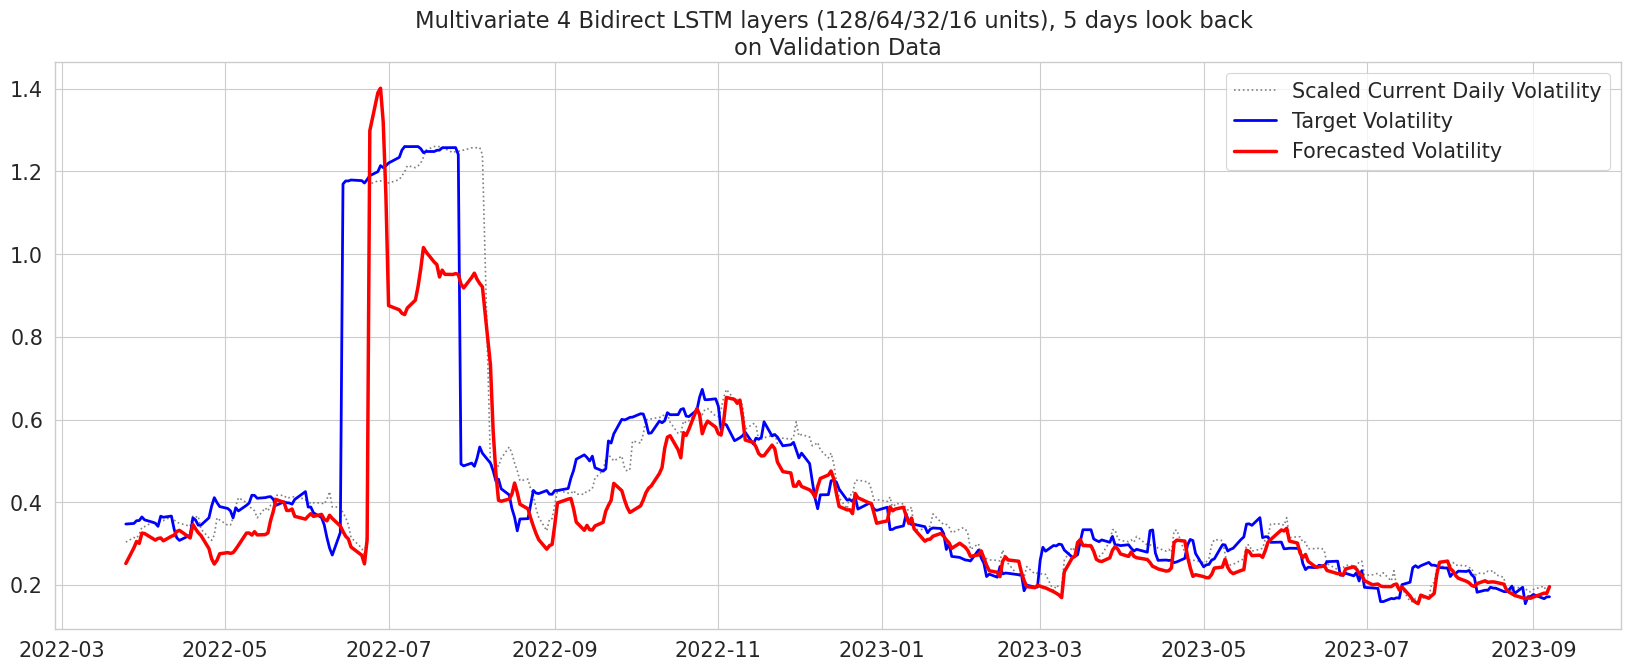

In [222]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), {n_past} days look back")
# plt.savefig(os.path.join(directory_to_img, 'lstm_7_preds.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [223]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                                                  Mean Baseline   
1                                                  Random Walk Naive Forecasting   
2                                         GARCH(1,1), Constant Mean, Normal Dist   
3                         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6                            Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                                         Simple LR Fully Connected NN, n_past=3   
8                                                LSTM 1 layer 20 units, n_past=3   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=3   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
11                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
12                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
13                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=5   
14                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=5   
15  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=5, batch=64   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152  
11          0.378170         0.289242  
12          0.378170         0.289242  
13          0.229656         0.164826  
14          0.235314         0.166773  
15          0.230702         0.167271

In [225]:
import talos


In [226]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])
    
    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [227]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [229]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)


100%|████████████████████████████████████████████████████████████████████████████████████| 36/36 [04:14<00:00,  7.07s/it]


In [230]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

start              end   duration  round_epochs      loss  \
11  11/06/23-230256  11/06/23-230306  10.334306            10  0.000117   
10  11/06/23-230241  11/06/23-230255  13.348499            10  0.000080   
26  11/06/23-230436  11/06/23-230444   7.940247            10  0.000080   

       rmspe  val_loss  val_rmspe  dropout activation  lstm_layers  batch_size  
11  0.709459  0.000172   0.274703      0.1       tanh            4          64  
10  0.553566  0.000201   0.291524      0.1       tanh            4          32  
26  0.556419  0.000191   0.292863      0.2       tanh            3          32

In [231]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5, 4)              16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 5, 64)             9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [232]:
# FITTING TO TRAINING DATA
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

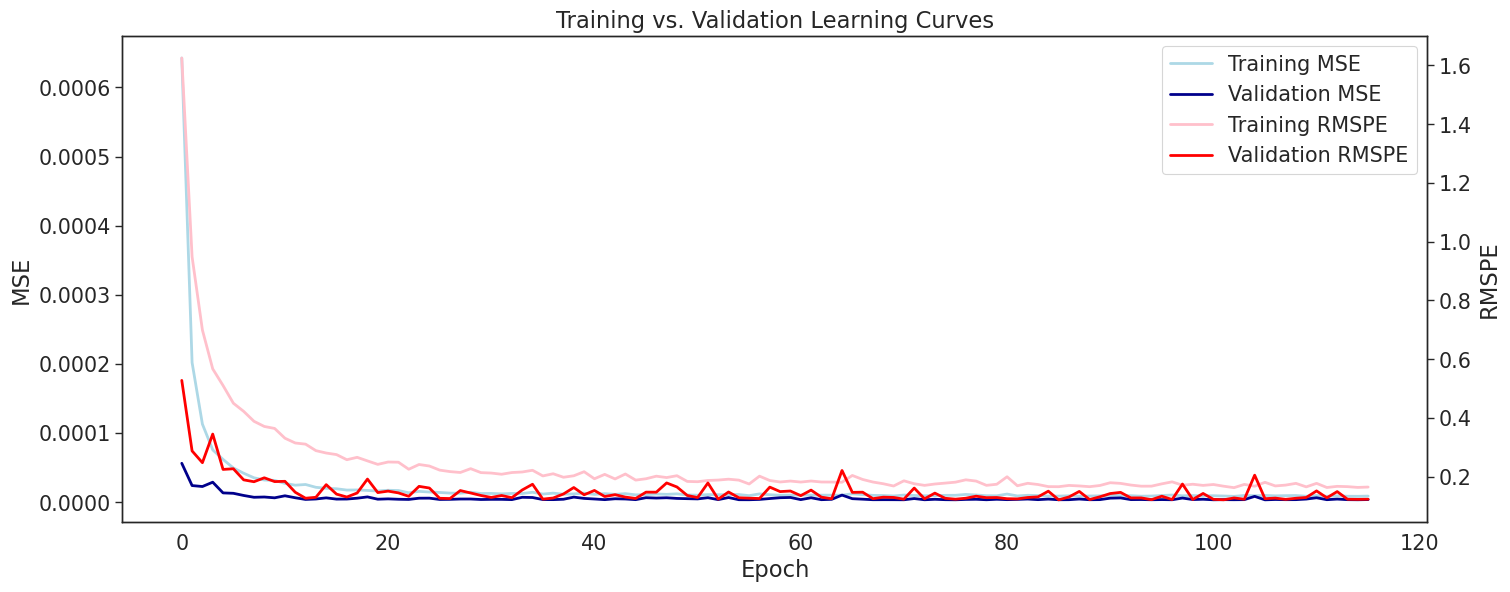

In [233]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_8_res)

In [234]:
# FORECASTING ON VALIDATION SET
lstm_8_preds = forecast_multi(lstm_8, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)

12/12 [==============================] - 1s 1ms/step


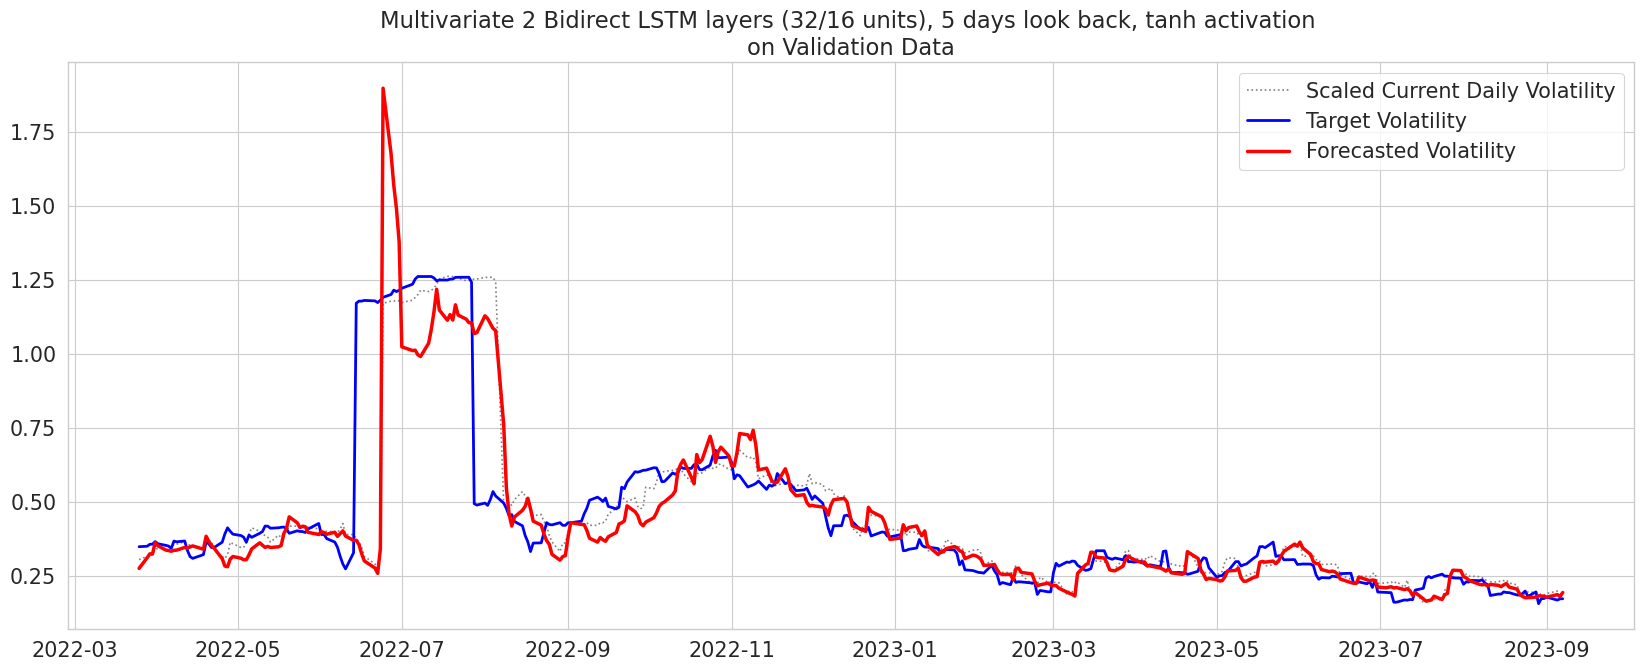

In [235]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_8_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back, tanh activation")
# plt.savefig(os.path.join(directory_to_img, 'lstm_8_preds.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [236]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past={n_past}, batch={batch_size}, tanh")

Model  \
0                                                                  Mean Baseline   
1                                                  Random Walk Naive Forecasting   
2                                         GARCH(1,1), Constant Mean, Normal Dist   
3                         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6                            Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
7                                         Simple LR Fully Connected NN, n_past=3   
8                                                LSTM 1 layer 20 units, n_past=3   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=3   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
11                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
12                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
13                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=5   
14                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=5   
15  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=5, batch=64   
16   Multivariate 2 Bidirect LSTM layers (32/16 units), n_past=5, batch=32, tanh   

    Validation RMSPE  Validation RMSE  
0           0.456495         0.345204  
1           0.271457         0.164036  
2           0.286458         0.182267  
3           0.287416         0.194658  
4           0.239530         0.191904  
5           0.239770         0.191769  
6           0.232137         0.192078  
7           0.264820         0.172304  
8           0.280994         0.159221  
9           0.250677         0.164278  
10          0.235032         0.167152  
11          0.378170         0.289242  
12          0.378170         0.289242  
13          0.229656         0.164826  
14          0.235314         0.166773  
15          0.230702         0.167271  
16          0.249626         0.168249

In [237]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  \
13                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=5   
15  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=5, batch=64   
6                            Bootstrap TARCH(2, 2, 1), Constant Mean, Skewt Dist   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=4, batch=64   
14                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=5   
4                                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
16   Multivariate 2 Bidirect LSTM layers (32/16 units), n_past=5, batch=32, tanh   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=3   
7                                         Simple LR Fully Connected NN, n_past=3   
1                                                  Random Walk Naive Forecasting   
8                                                LSTM 1 layer 20 units, n_past=3   
2                                         GARCH(1,1), Constant Mean, Normal Dist   
3                         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
12                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
11                  2 Bidirect LSTMs (32/16), n_past=5, batch=64, SGD lr=6.9e-05   
0                                                                  Mean Baseline   

    Validation RMSPE  Validation RMSE  
13          0.229656         0.164826  
15          0.230702         0.167271  
6           0.232137         0.192078  
10          0.235032         0.167152  
14          0.235314         0.166773  
4           0.239530         0.191904  
5           0.239770         0.191769  
16          0.249626         0.168249  
9           0.250677         0.164278  
7           0.264820         0.172304  
1           0.271457         0.164036  
8           0.280994         0.159221  
2           0.286458         0.182267  
3           0.287416         0.194658  
12          0.378170         0.289242  
11          0.378170         0.289242  
0           0.456495         0.345204

In [238]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [243]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 3
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 3, 4)              16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 3, 64)             9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [244]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

 17%|██████████████▏                                                                      | 6/36 [08:22<41:53, 83.78s/it]


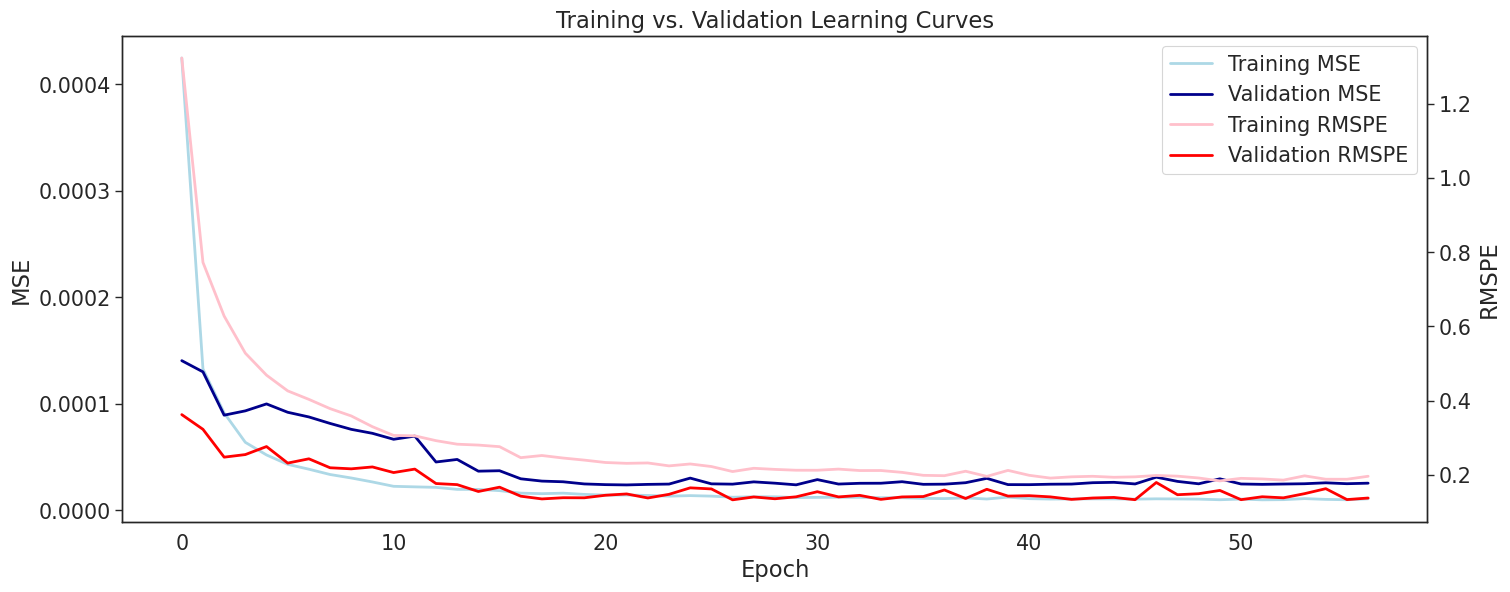

In [245]:
viz_train_val_metrics(lstm_final_res)

In [246]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

1/1 [==============================] - 1s 719ms/step


In [247]:
y_test_preds.describe()

count    30.000000
mean      0.014925
std       0.000729
min       0.014006
25%       0.014470
50%       0.014867
75%       0.015079
max       0.017612
dtype: float64

In [248]:
y_test.describe()

count    30.000000
mean      0.014018
std       0.000838
min       0.012176
25%       0.013714
50%       0.014380
75%       0.014535
max       0.014761
Name: vol_future, dtype: float64

In [249]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [250]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [ ]:
perf_df.to_pickle("performance_df.pkl")

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

In [ ]:
1-RMSPE(y_test, y_test_preds)

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

In [ ]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

In [ ]:
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

plt.show();

In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [ ]:
X_train.head()

In [ ]:
input_df.head()

In [ ]:
input_df.info()

In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

In [ ]:
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

In [ ]:
viz_train_val_metrics(lstm_5_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

In [ ]:
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

plt.show();


In [ ]:
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

In [ ]:
!pip install talos


In [ ]:
import talos

In [ ]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])
    
    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [ ]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 5
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)